#Unsupervised learning methods to dimensionality reduction of dataset
## Machine Learning Course, BDA 2021/2022
### author: Karolina Anna Schmidt
### index: 224763


###Problem
We got the dataset of raw signals data, where domestic female rats are recorded during various situations like game or trick training with the breeder, tickling, rats herds connection. 

As a data acquvisior I noted that rats voice is recorded only on small part of the dataset. Data have been collected since april 2020, so now dataset contains 400 116 files of length 0.125 seconds. Rats can emit very short sound signals and because choosen interval satisfies input reqiurements of further project, which is rats emotions classification. Manual review of that amount of data can sepnd long time for one and even more people.

For this process data must be also propeprocessed by time-frequency analysis methods, because rat voice signal is not stationary (which means that mean of signal change with time), and results must be presented with spectrogram of selected transormation (in this case Gabor transform).

Data is recorded on osciliscope Rigol with minimal sampling rate 100kHz (for elder rats - over 2 years) and 174kHz for younger rats (between 6 weeks and 2 years). With growing rats voice has lower signal frequency. From Nyquist theorem sampling rate must to be minimul 2x bigger than primary frequency. In another case occurs aliasing. Records are saved in wfm format.
###Solution approach
We can treat voice occurence as anomaly, because it appers only in small part of dataset. Because dataset is not labeled we cannot use supervised methods of machine learning. Our approach is unsupervised learning to anomaly detection. The goal is to make a model, which will train a main pattern of the dataset and will incorrectly process outliers. Comparision of sample and its prediction should give big recognizion error (L2 norm) for outliers. 
###Model
Selected model is Denoising Autoencoder. This model first encodes input and then decodes it to the input format. Goal of model is dimensionality reduction of input data. This model is sensitive to the outliers. It reconstruct the main pattern of samples, outliers are mostly skip.

## Part 1: Preprocess data and training the model

In [1]:
!pip install RigolWFM

In [1]:
import os
import sys
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras import Input, Model

In [2]:
#folder with raw signal files
source_code_path = "/content/drive/MyDrive/source_code"
sys.path.append(source_code_path)

In [28]:
from signal_preprocessing import random_rat_batch_generator, open_wfm_file, get_stft,\
                                 get_random_filtered_intervals, filtered_intervals_generator_to_predict
from constants import *

In [19]:
input_path = "/content/drive/MyDrive/input"

### Batch generator
Becuase amount of raw data weights around 9GB, loading the entire dataset at once will take up all RAM. In deep learning is normal that datasets are big because then we can got better predictions. To avoid situation when we will ran out of RAM, tensorflow models can take generator as input. Generator returns one record every iteration and calculates it in the fly.
Method random_rat_batch_generator(input_path) makes generator which returns a batches with specified size of samples in each iteration. Model in one evaluation trains on one batch of data.
Selected batch size: 256 

In [ ]:
def make_generator():
  with tf.device('/cpu:0'):
      batch_generator = random_rat_batch_generator(input_path)
      return batch_generator

###Model


In [ ]:
batch_generator = make_generator()
input_shape = INPUT_SHAPE
encoding_dim = 30
input_s = Input(shape=(input_shape,))
# encoded representation of input
encoded = Dense(encoding_dim, activation='relu')(input_s)
# decoded representation of code 
decoded = Dense(input_shape, activation='sigmoid')(encoded)
# Model which take input image and shows decoded images
autoencoder = Model(input_s, decoded)

# This model shows encoded images
encoder = Model(input_s, encoded)
# Creating a decoder model
encoded_input = Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# def run_model():
  # with tf.device('/device:tpu:0'):

history = autoencoder.fit_generator(batch_generator,
                                epochs=20,
                                steps_per_epoch=50)


encoder.save("/content/drive/MyDrive/tnew_encoder.h5")
decoder.save("/content/drive/MyDrive/tnew_decoder.h5")
autoencoder.save("/content/drive/MyDrive/tnew_autoencoder.h5")


import pickle as pkl

with open("/content/drive/MyDrive/thistory.pkl", "wb") as f:
    pkl.dump(history, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
50/50 [==============================] - 161s 3s/step - loss: 0.5786
Epoch 2/20
50/50 [==============================] - 162s 3s/step - loss: 12.5030
Epoch 3/20
50/50 [==============================] - 179s 3s/step - loss: 2.8268
Epoch 4/20
50/50 [==============================] - 172s 3s/step - loss: 0.0571
Epoch 5/20
50/50 [==============================] - 184s 4s/step - loss: 0.0578
Epoch 6/20
50/50 [==============================] - 174s 4s/step - loss: 0.9238
Epoch 7/20
50/50 [==============================] - 173s 3s/step - loss: 9.4059
Epoch 8/20
50/50 [==============================] - 167s 3s/step - loss: 0.0519
Epoch 9/20
50/50 [==============================] - 181s 4s/step - loss: 0.0696
Epoch 10/20
50/50 [==============================] - 181s 4s/step - loss: 0.0299
Epoch 11/20
50/50 [==============================] - 176s 3s/step - loss: 0.0729
Epoch 12/20
50/50 [==============================] - 183s 4s/step - loss: 0.0574
Epoch 13/20
50/50 [=================

In [ ]:
#save model history
with open("/content/drive/MyDrive/history.pkl", "wb") as f:
    pkl.dump(history, f)

INFO:tensorflow:Assets written to: ram://3d3428b3-2c04-436e-ade3-69e0e0cfe873/assets


In [ ]:
#save model
encoder.save("/content/drive/MyDrive/tnew_encoder.h5")
decoder.save("/content/drive/MyDrive/tnew_decoder.h5")
autoencoder.save("/content/drive/MyDrive/tnew_autoencoder.h5")

##Part 2: Results analysis

In [10]:
with open("/content/drive/MyDrive/history.pkl", "rb") as f:
  history = pkl.load(f)

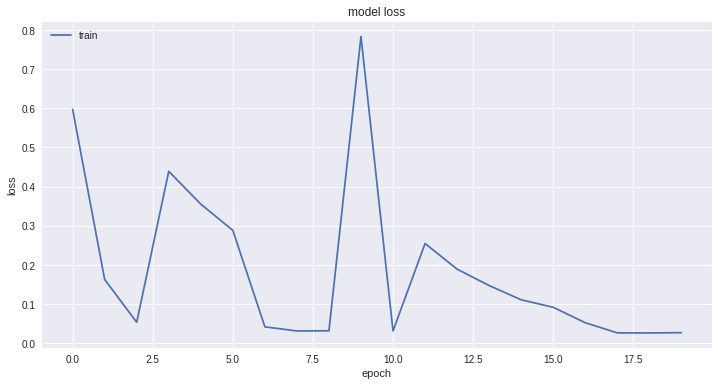

In [12]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn')
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
from keras.models import load_model
autoencoder = load_model(AUTOENCODER_PATH)
encoder = load_model(ENCODER_PATH)
decoder = load_model(DECODER_PATH)

In [5]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14124)]           0         
                                                                 
 dense (Dense)               (None, 30)                423750    
                                                                 
 dense_1 (Dense)             (None, 14124)             437844    
                                                                 
Total params: 861,594
Trainable params: 861,594
Non-trainable params: 0
_________________________________________________________________


In [6]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14124)]           0         
                                                                 
 dense (Dense)               (None, 30)                423750    
                                                                 
Total params: 423,750
Trainable params: 423,750
Non-trainable params: 0
_________________________________________________________________


In [7]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_1 (Dense)             (None, 14124)             437844    
                                                                 
Total params: 437,844
Trainable params: 437,844
Non-trainable params: 0
_________________________________________________________________


#Recognizion error

In [37]:
def max_metric(X_test, X_pred):
    return np.max(recognizion_error(X_test, X_pred))

def recognizion_error(X_test, X_pred):
    return np.power(X_test - X_pred, 2)


I calculated max metric for all dataset and saved result in file `errors.npy`.

In [10]:
errors = REC_ERRORS

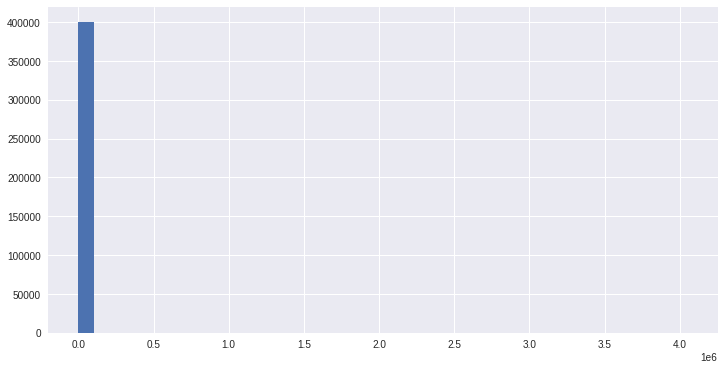

In [16]:
plt.style.use('seaborn')
plt.figure(figsize=(12,6))
plt.hist(errors, bins=40)
plt.show()

The most values oscilates near 0, but outliers can have very big values. I have to find valuable threhold to split dataset for common values and outliers.

For this I take one the most representative measurements. In this record are detected voices of few rats with various amplitude. I going  to make threshold which not reject any valuable signal in this file.

In [21]:
file_path = os.path.join(input_path, '2021_12_25/measurements/NewFile8.wfm')

In [24]:
time, signal, fp = open_wfm_file(file_path)
f, t, Sxx = get_stft(time, signal, fp)

Text(0.5, 0, 'Czas [s]')

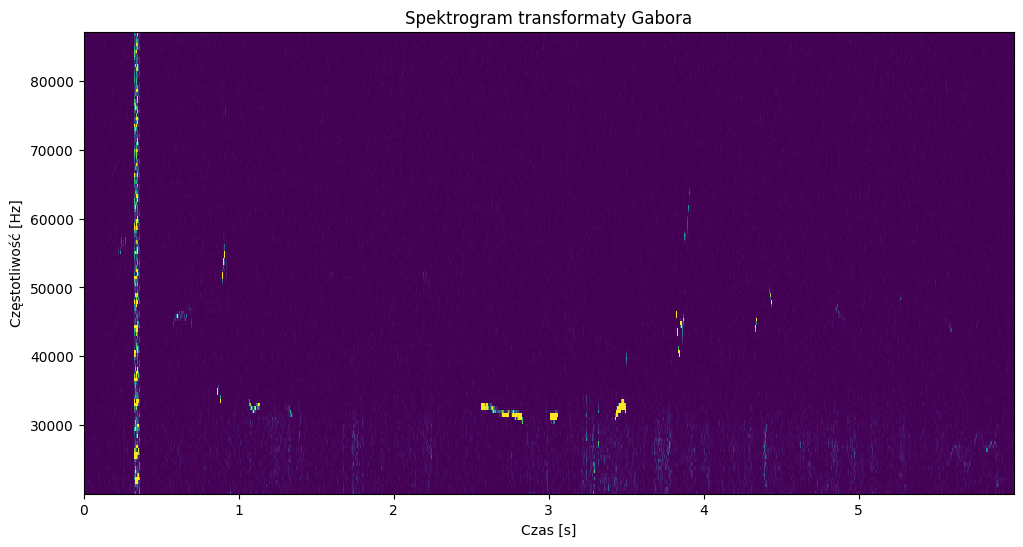

In [26]:
plt.style.use('default')
plt.figure(figsize=(12,6))
plt.pcolormesh(t, f, Sxx, vmax=0.5)
plt.title('Spektrogram transformaty Gabora')
plt.ylabel('Częstotliwość [Hz]')
plt.xlabel('Czas [s]')

The line on ~0.3 seconds is recording error and it is removed (owerwritten by reference) in preprocessing. Short signals with one harmonic or frequencies between 30 and 70 kHz are rat sounds. These ones means positivies emotions of rat. 
### Recognizion error threshold
I supposse that outliers are rat sounds. i define a threshold as nth percentile of metric for each sample. I will start with small value confidence level which is: \\
`confidence_level = 100-nth_percentile` \\
I will keep increasing the this value until all good signals are only in the selected set.

In [98]:
confidence_level = 0.05
percentile_value = 1 - confidence_level
perc = np.percentile(errors, percentile_value*100)

In [99]:
print(f"95th percentile: {perc}")

95th percentile: 0.9714895039796829


In [100]:
batch_size = 1
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
_ = next(stft_generator)
encoded_img = encoder.predict(stft_generator)
decoded_img = decoder.predict(encoded_img)
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
part_f, part_t = next(stft_generator)

In [101]:
i = 0
selected = []
rejected = []
for one_Sxx in stft_generator:
    metric = max_metric(one_Sxx, decoded_img[i])
    if metric > perc:
        selected.append(one_Sxx)
    else:
        rejected.append(one_Sxx)
    i += 1

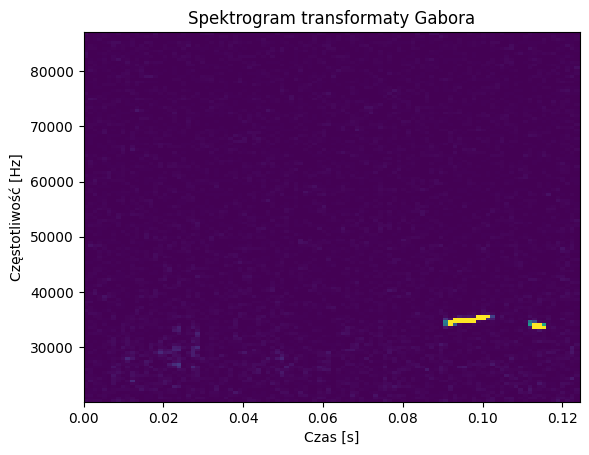

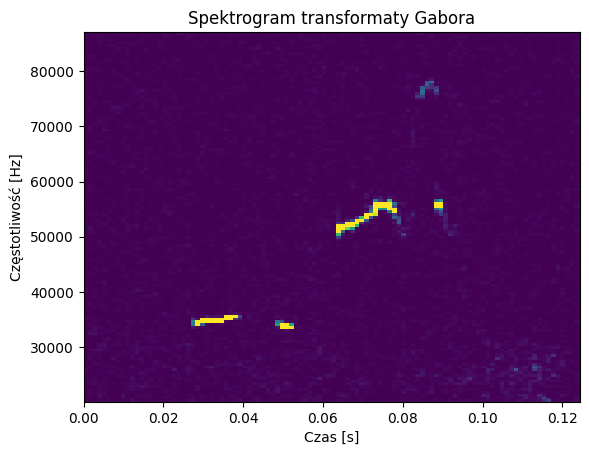

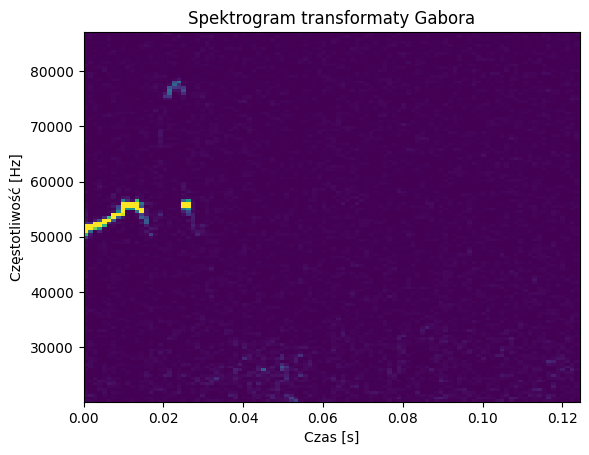

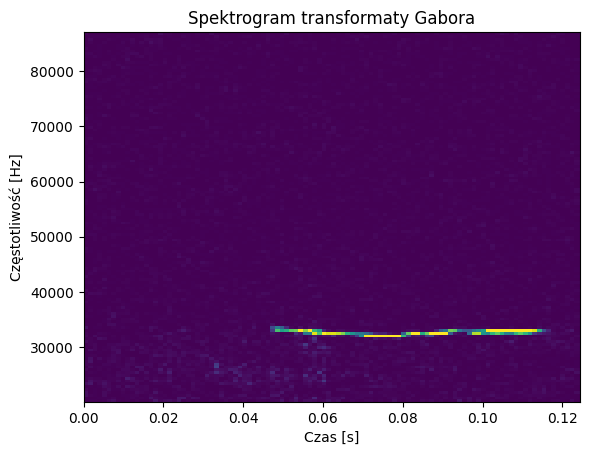

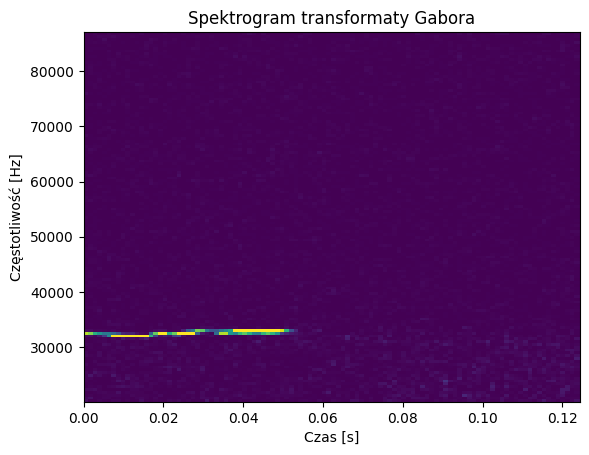

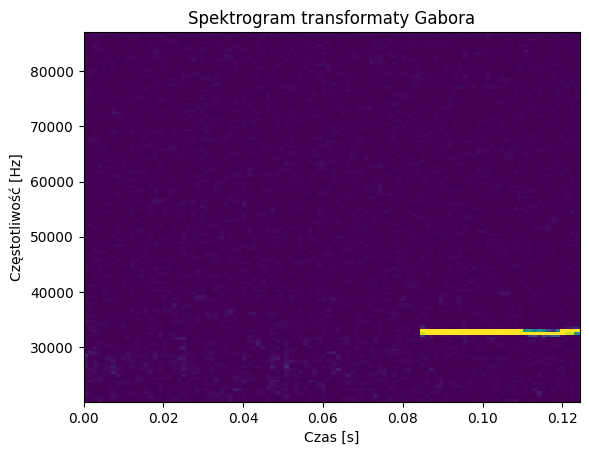

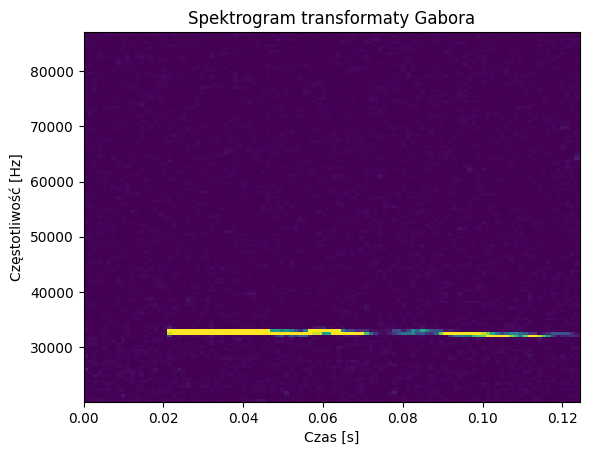

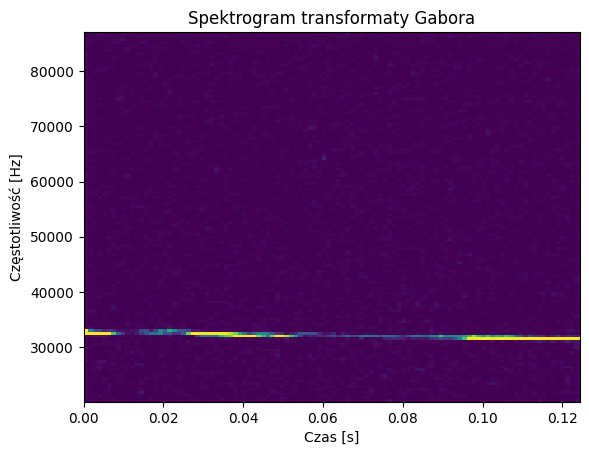

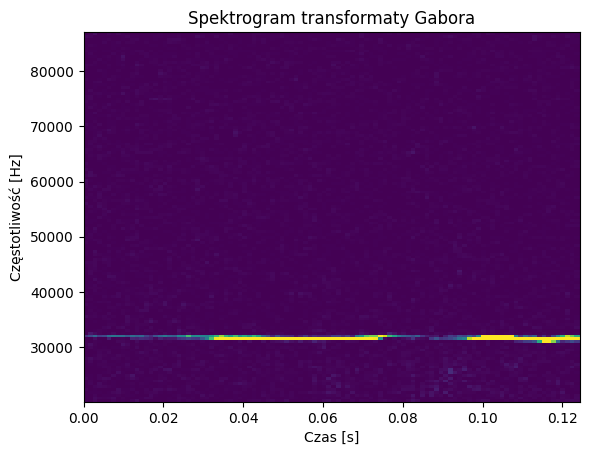

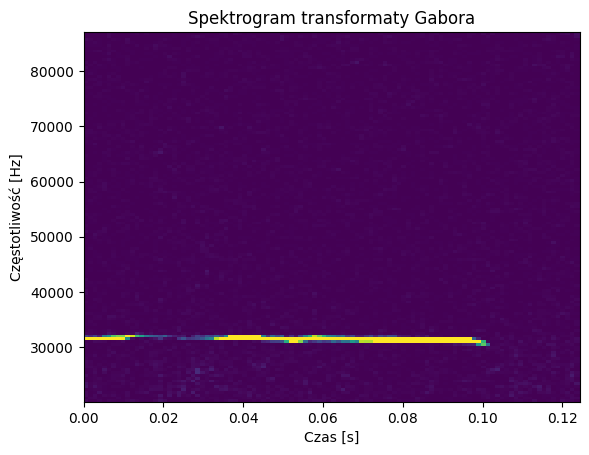

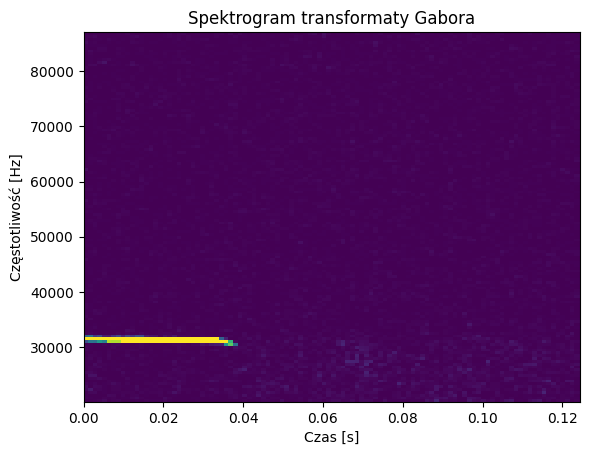

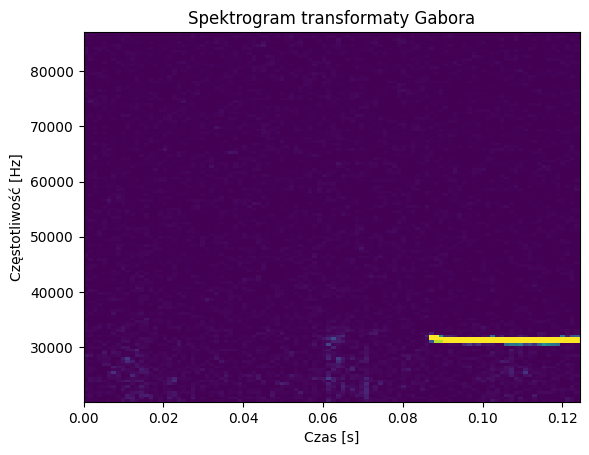

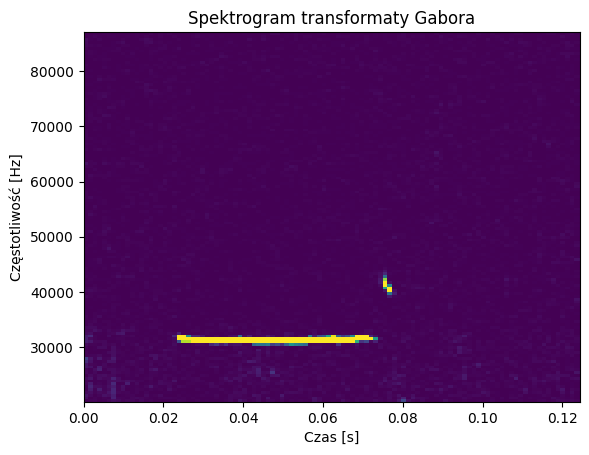

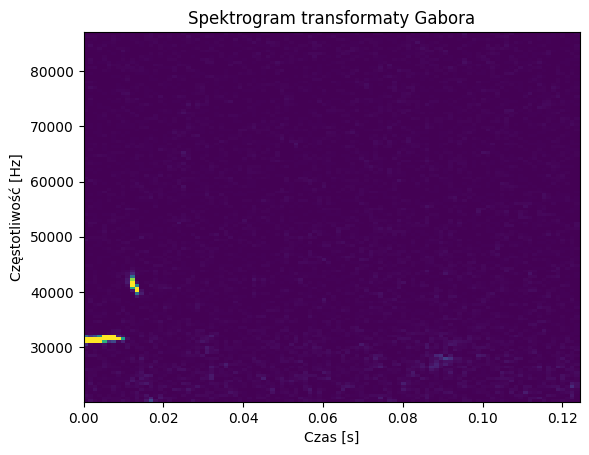

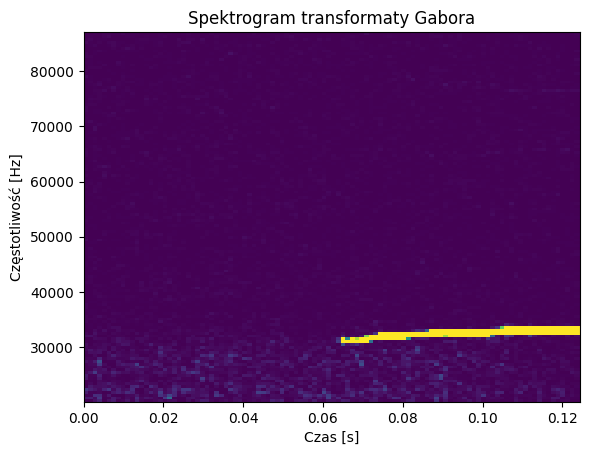

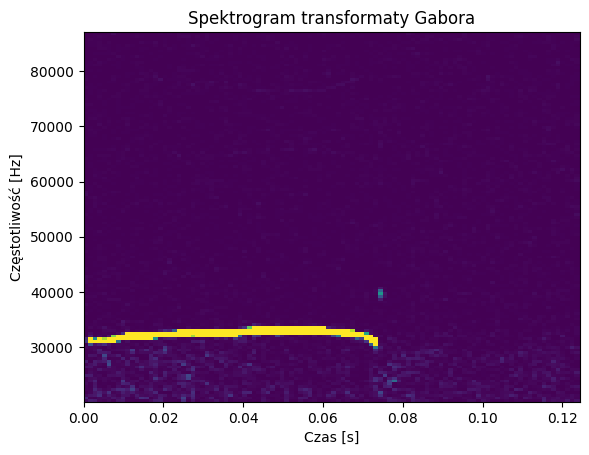

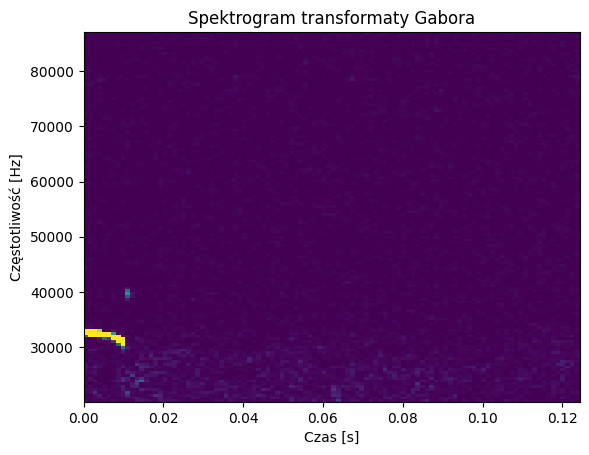

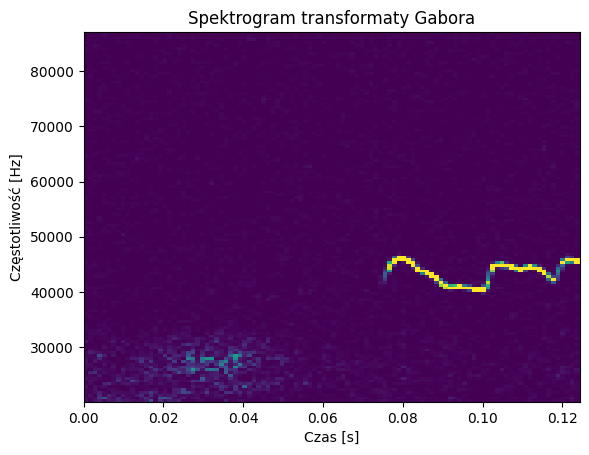

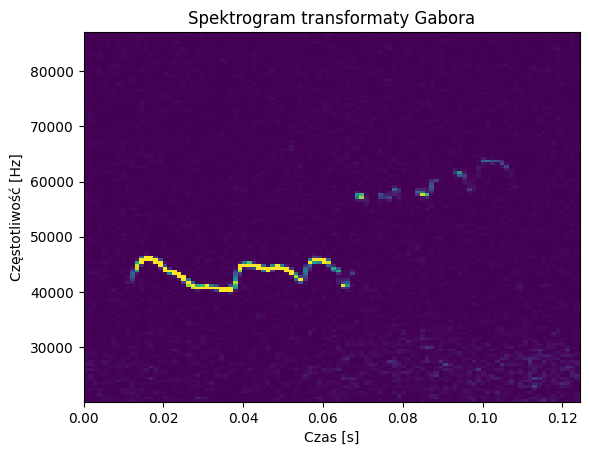

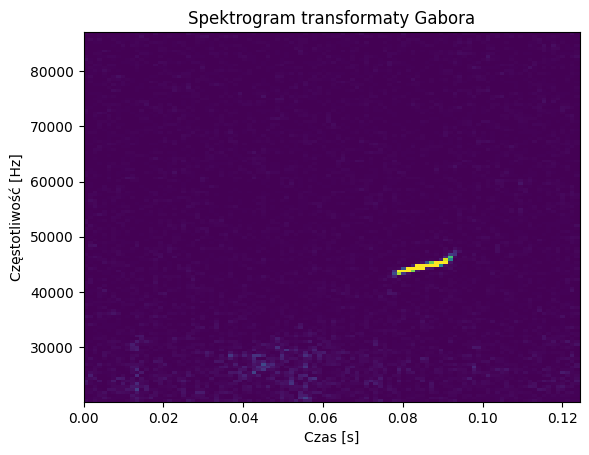

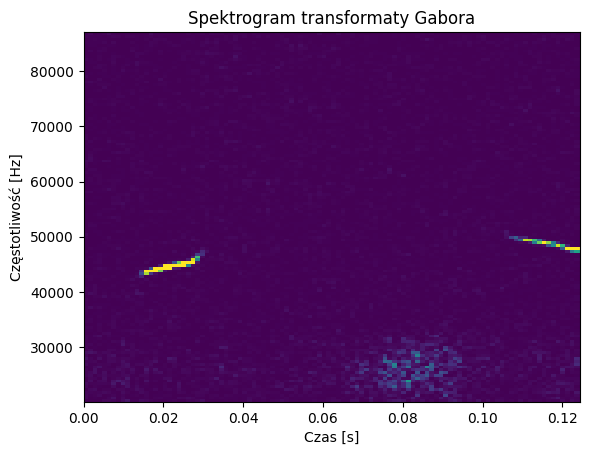

In [102]:
for one_selected in selected:
    plt.pcolormesh(part_t, part_f, one_selected.reshape(IMAGE_SHAPE), vmax=0.5)
    plt.title('Spektrogram transformaty Gabora')
    plt.ylabel('Częstotliwość [Hz]')
    plt.xlabel('Czas [s]')
    plt.show()

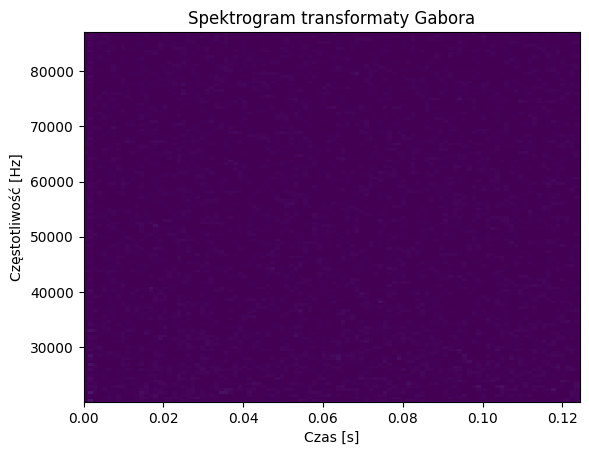

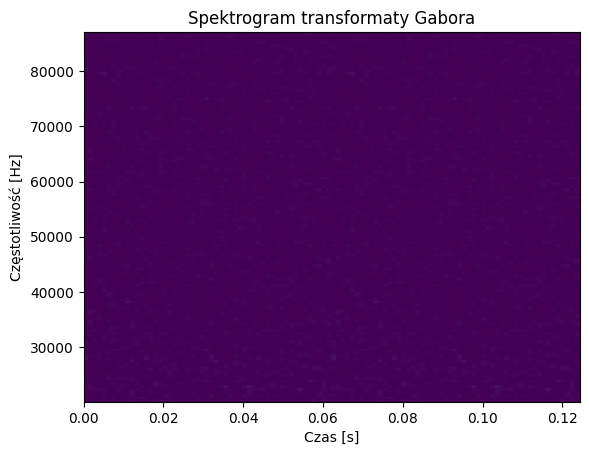

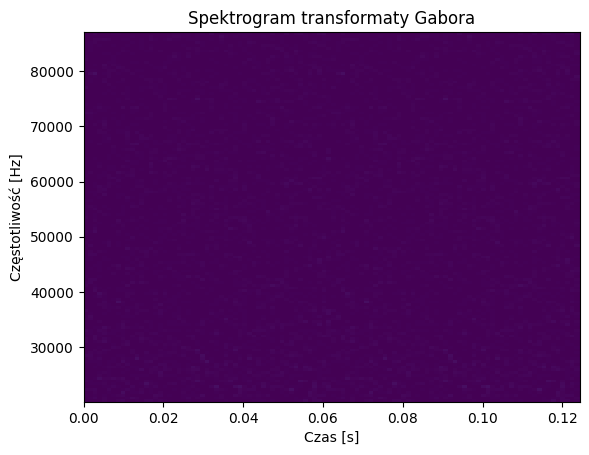

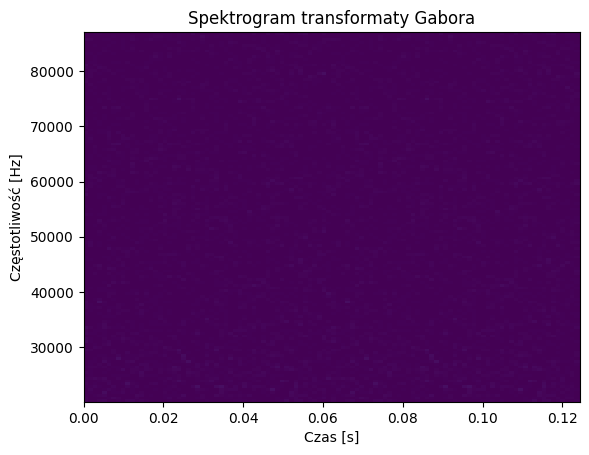

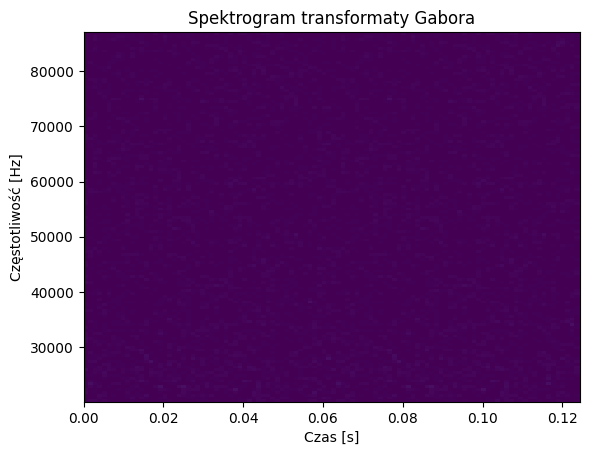

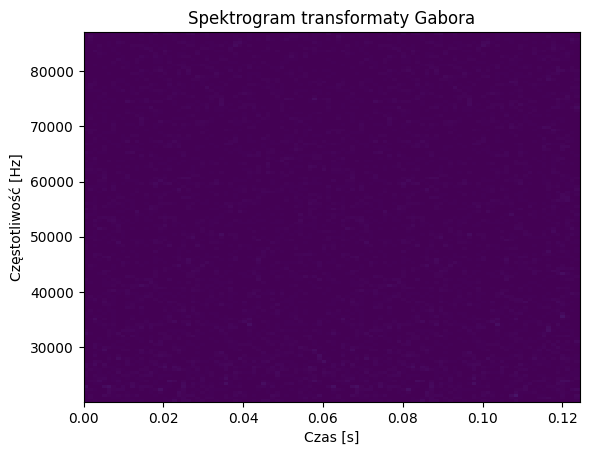

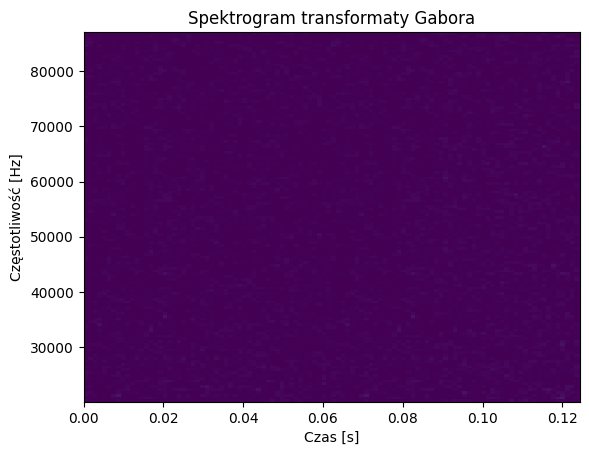

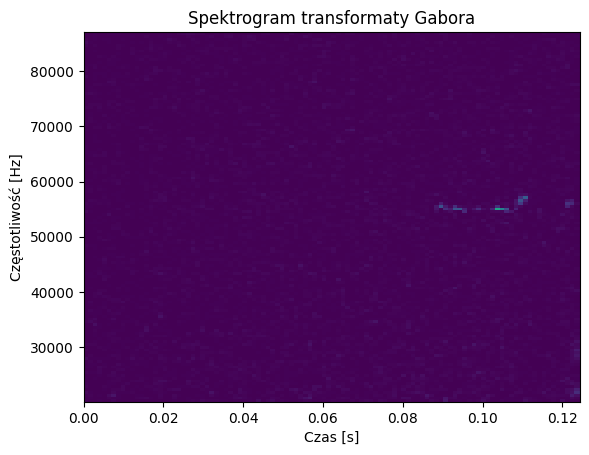

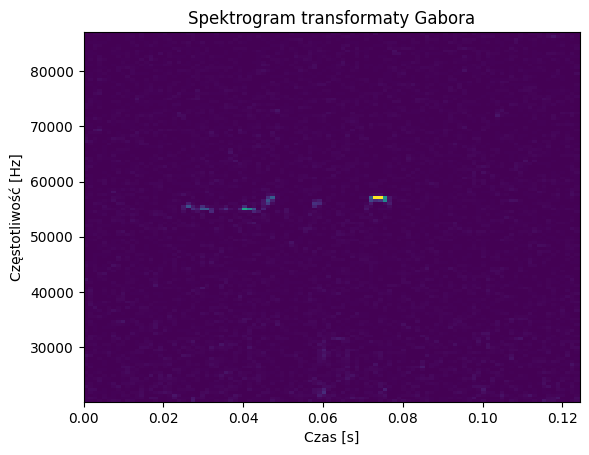

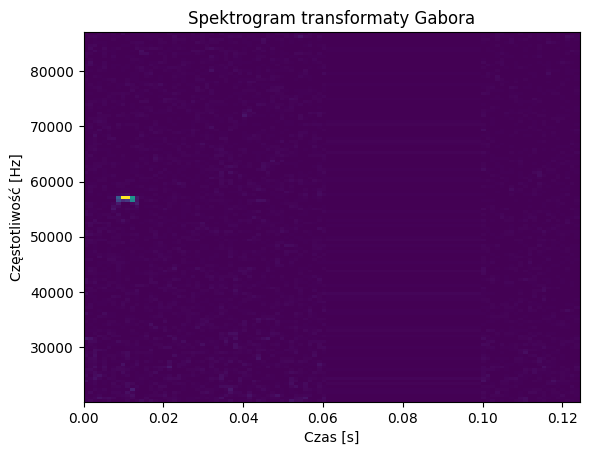

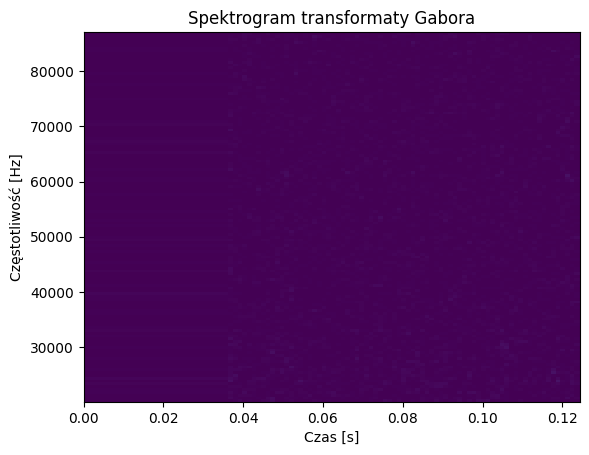

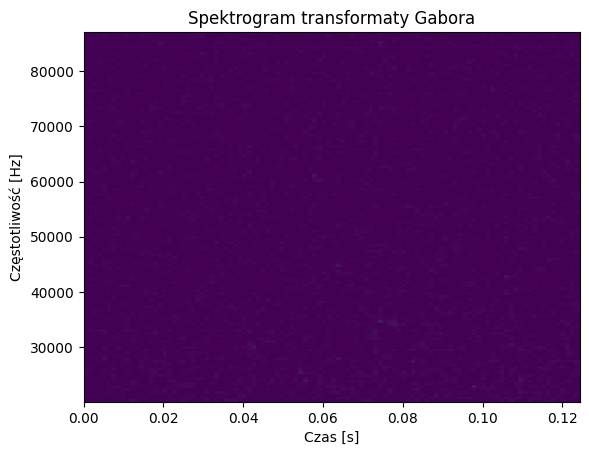

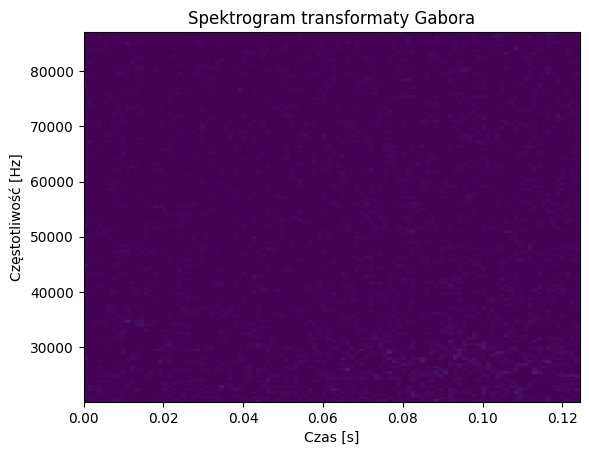

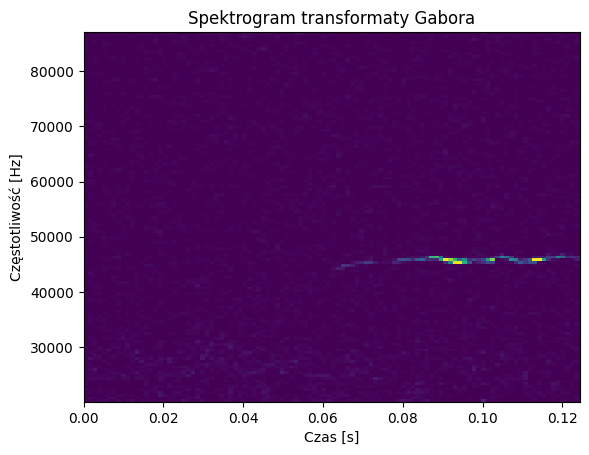

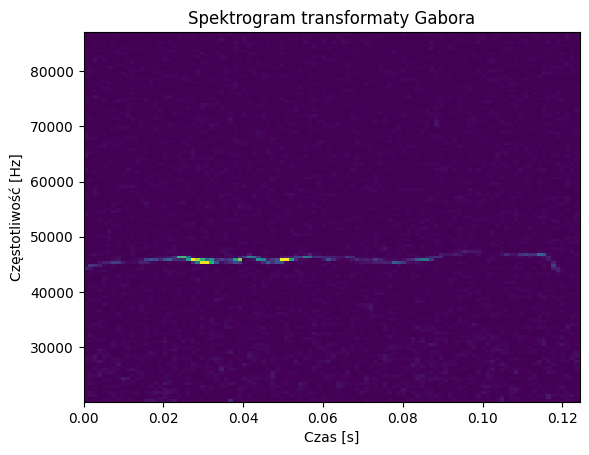

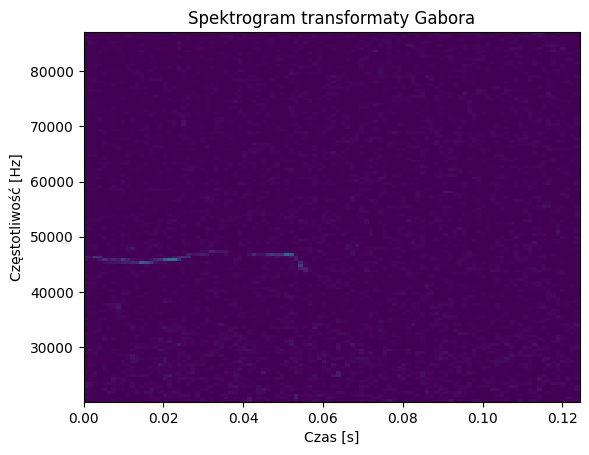

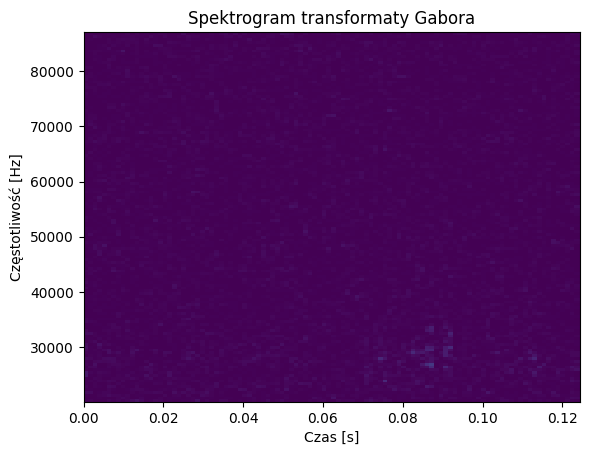

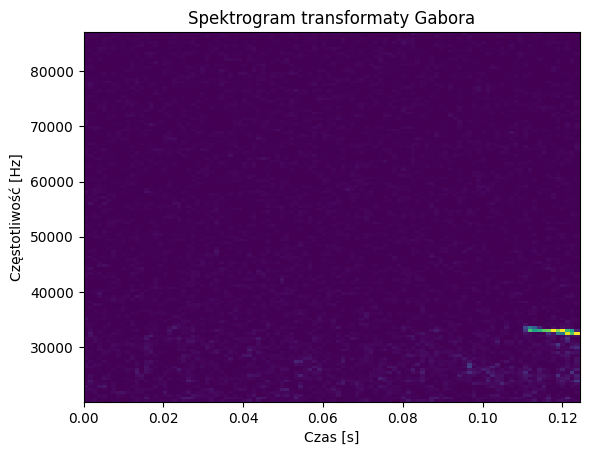

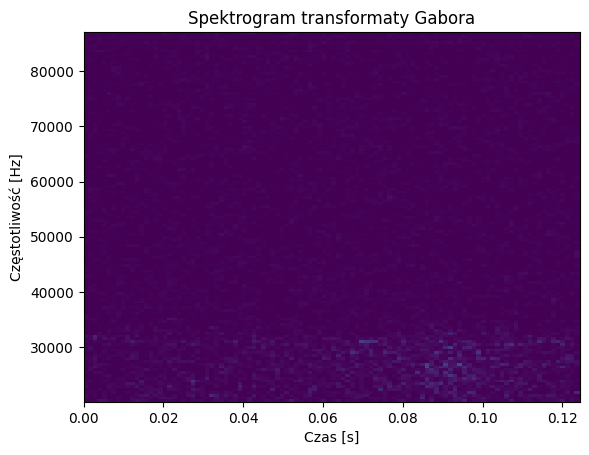

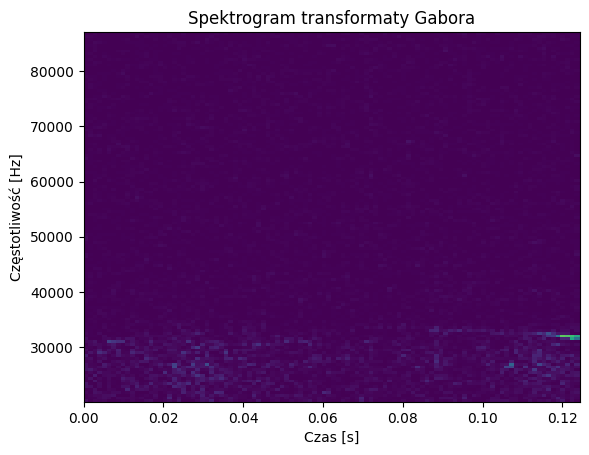

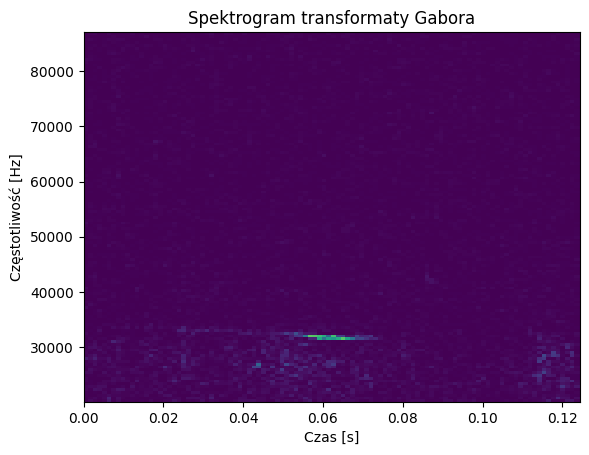

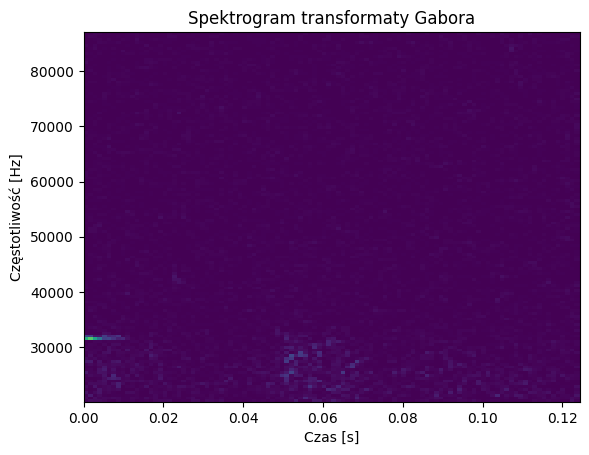

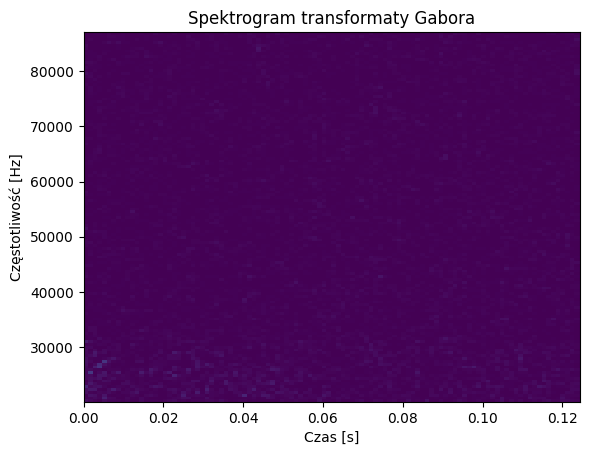

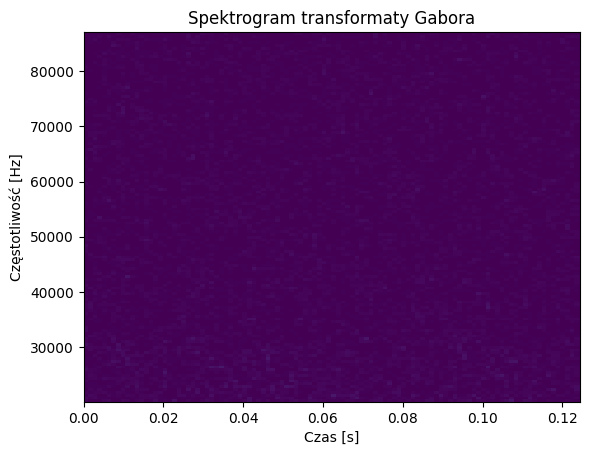

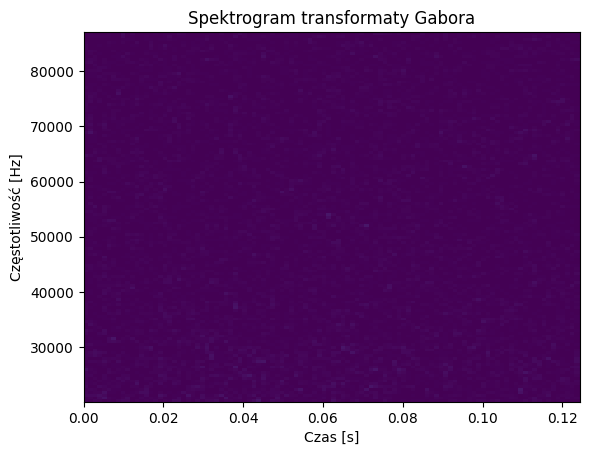

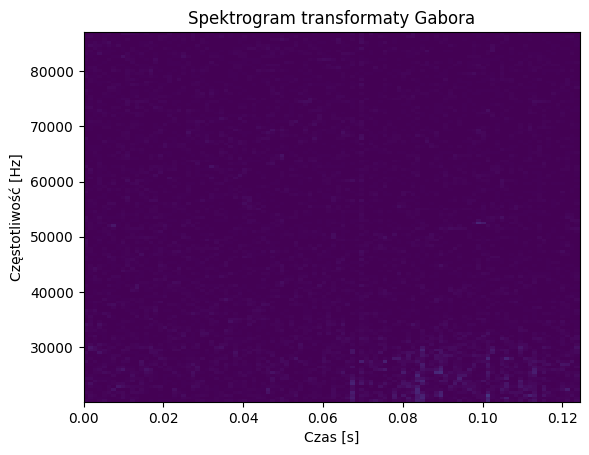

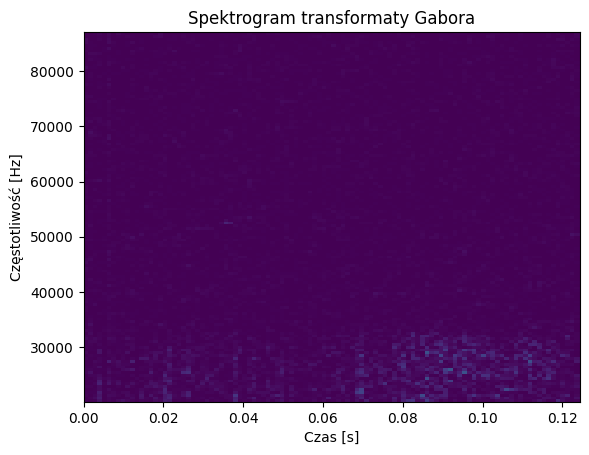

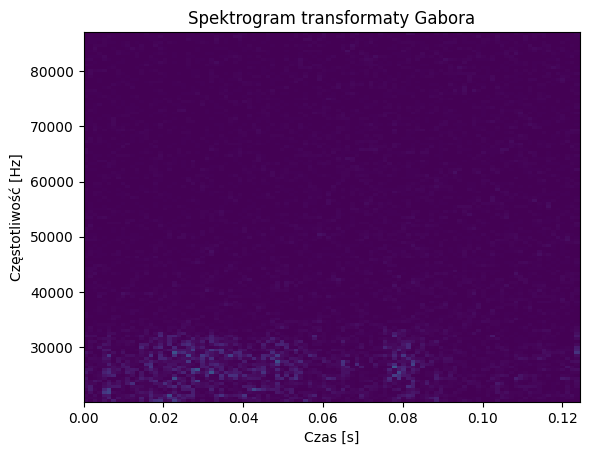

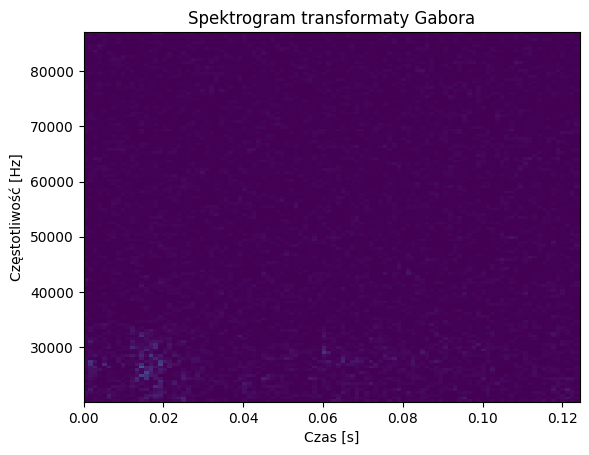

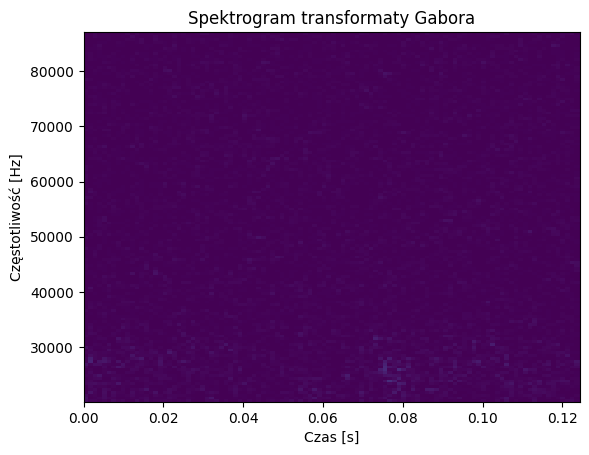

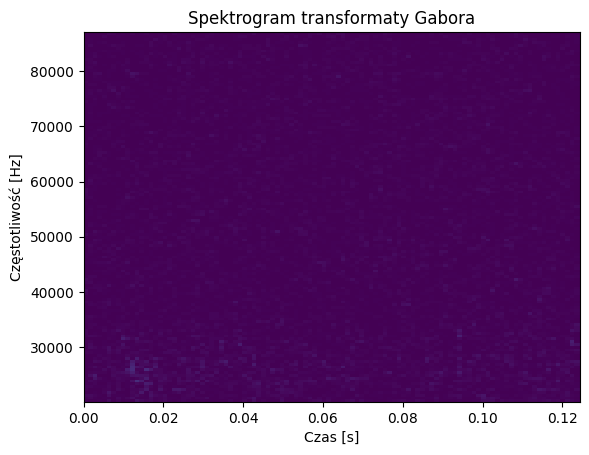

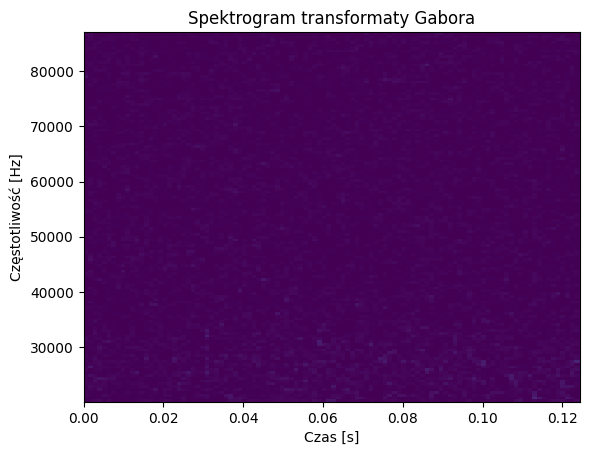

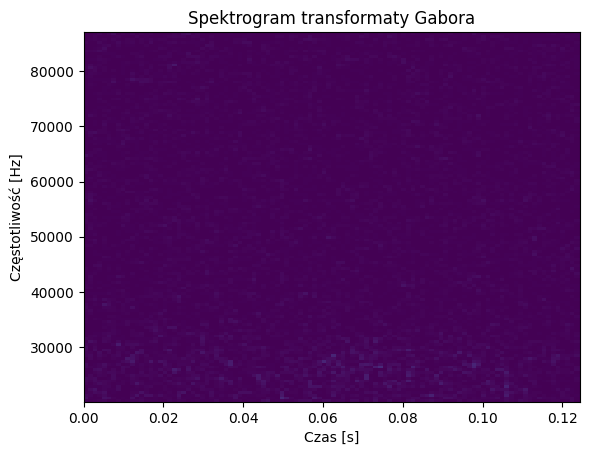

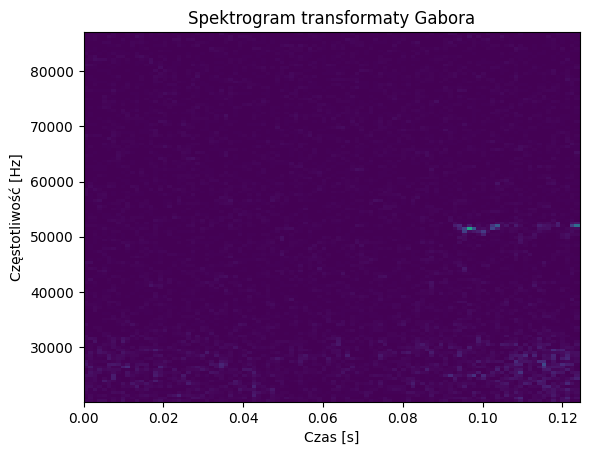

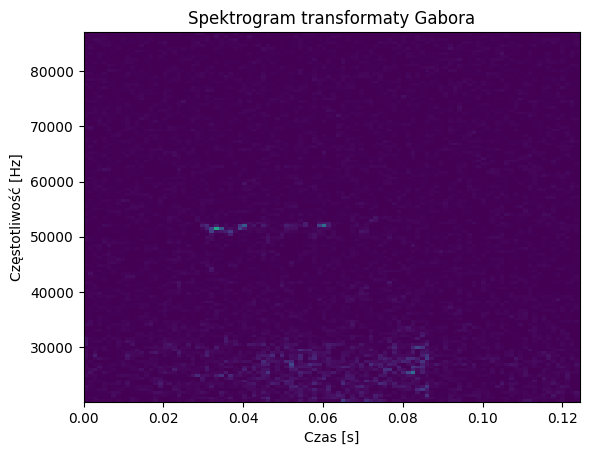

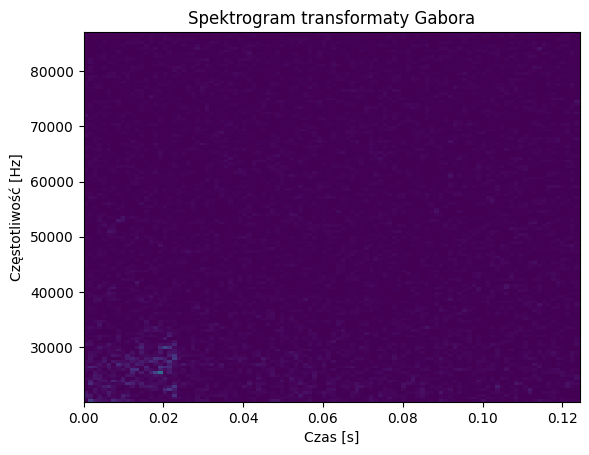

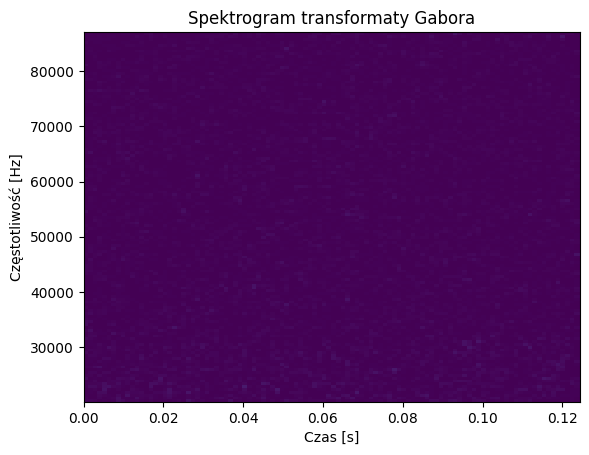

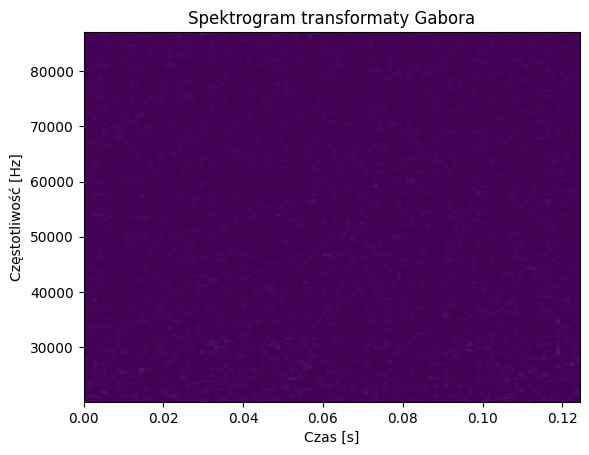

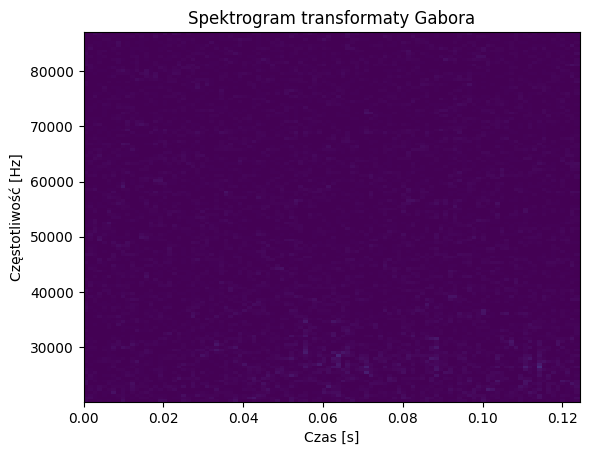

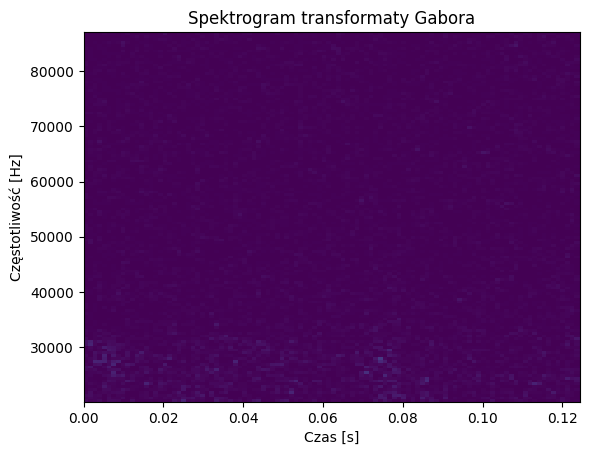

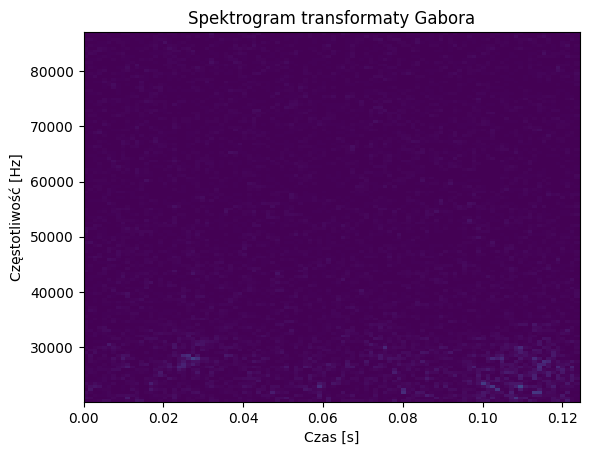

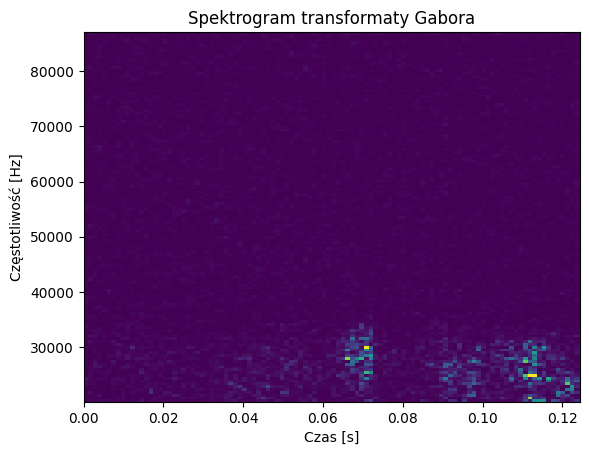

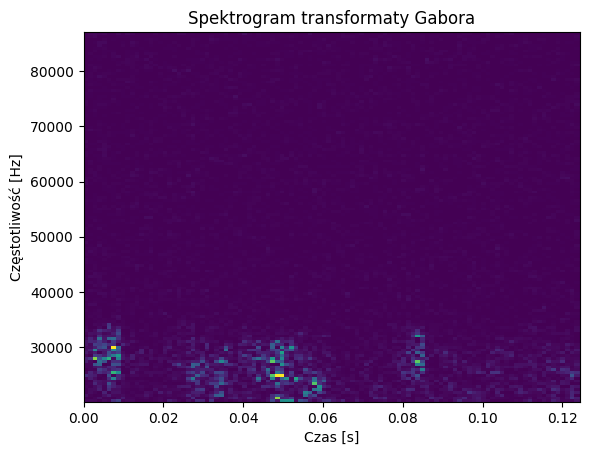

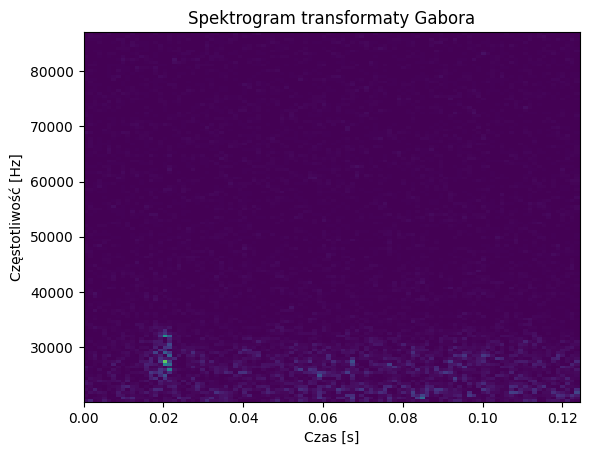

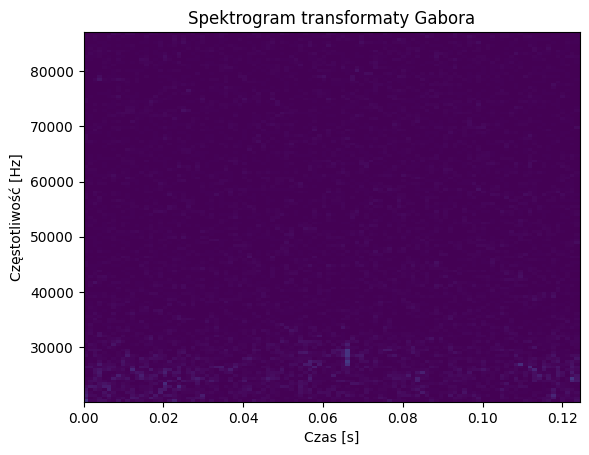

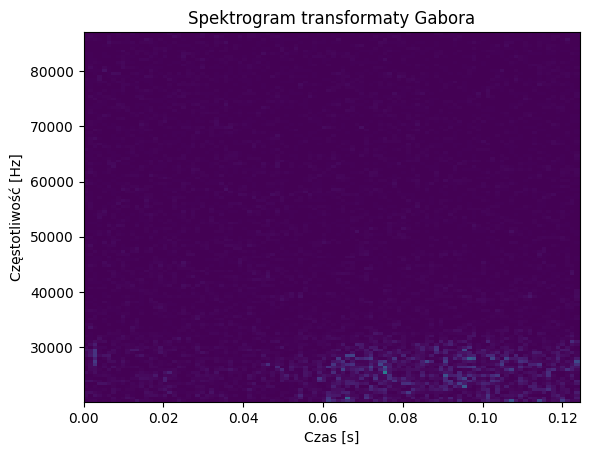

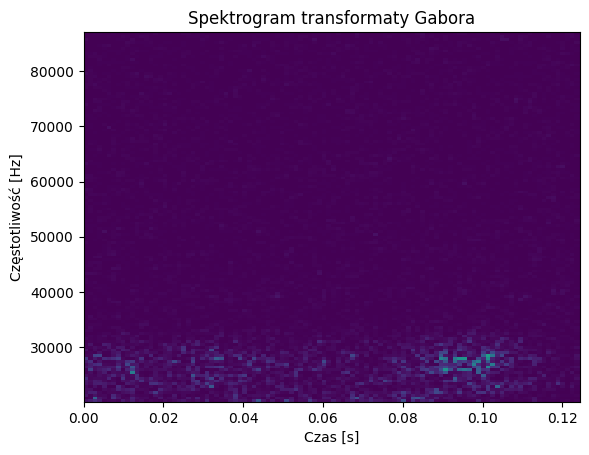

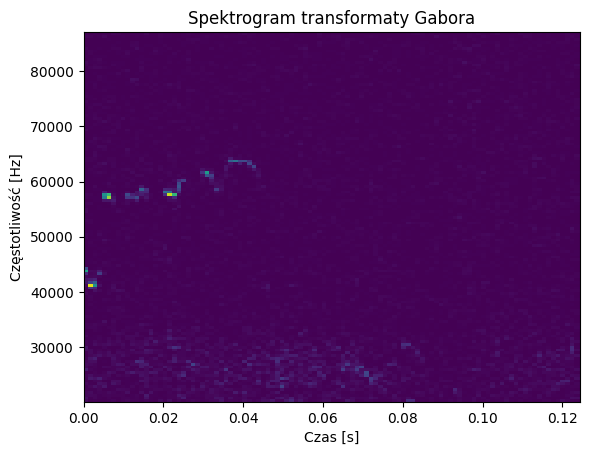

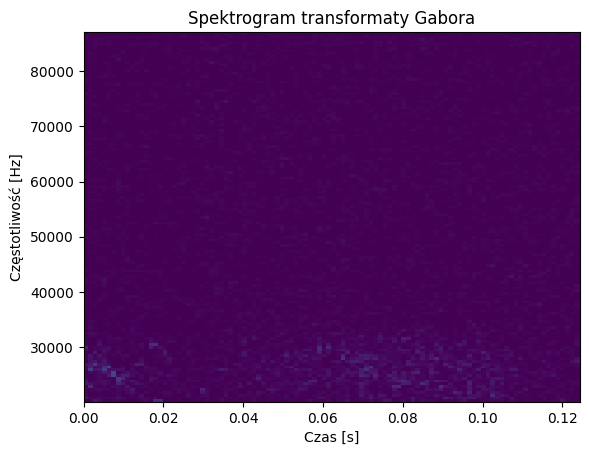

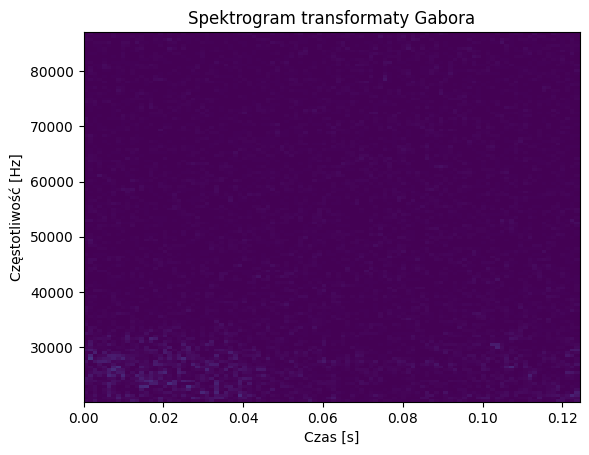

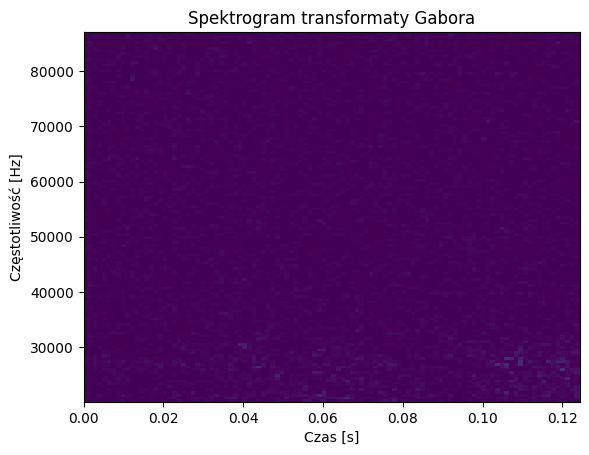

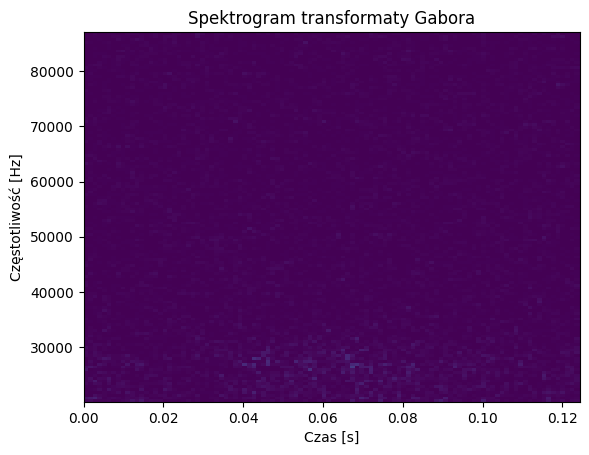

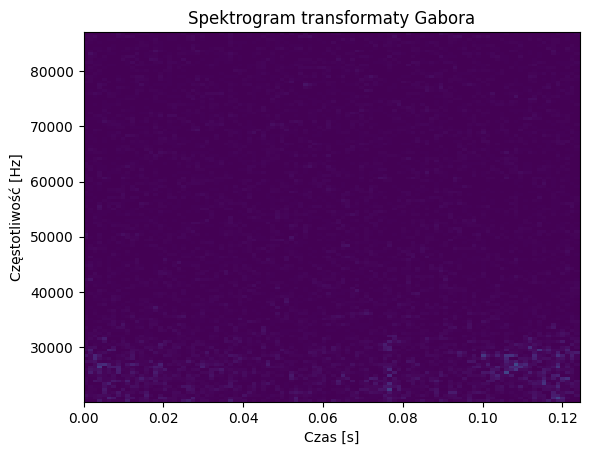

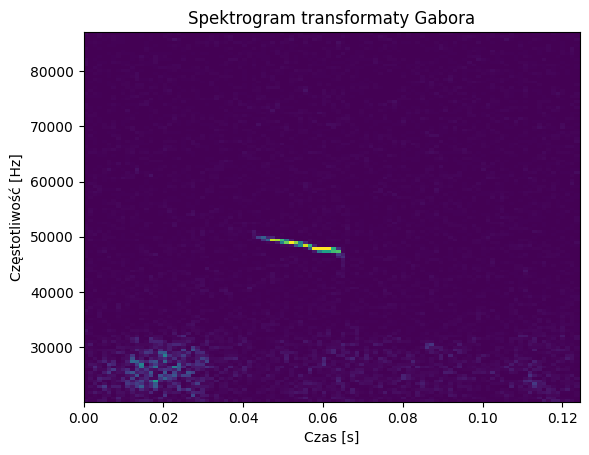

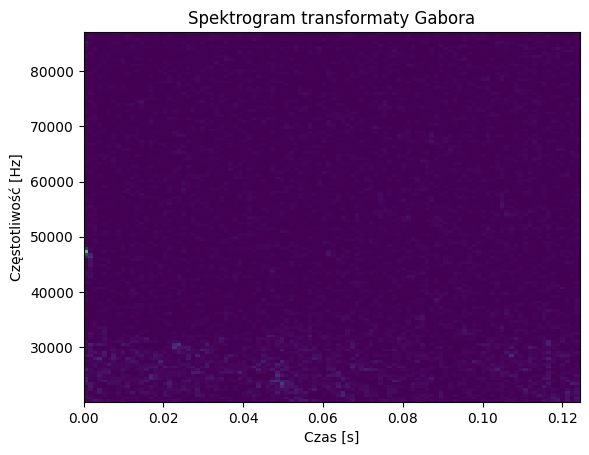

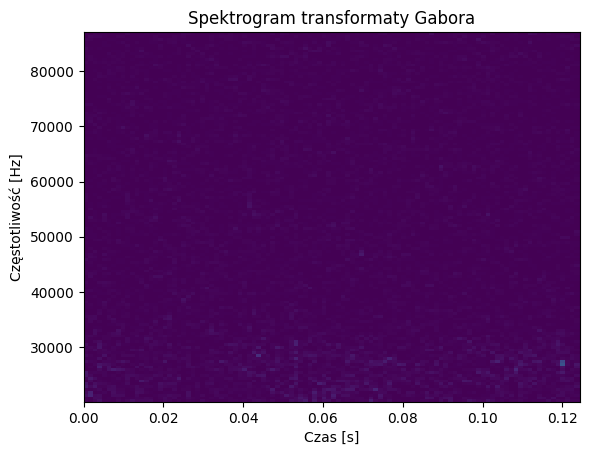

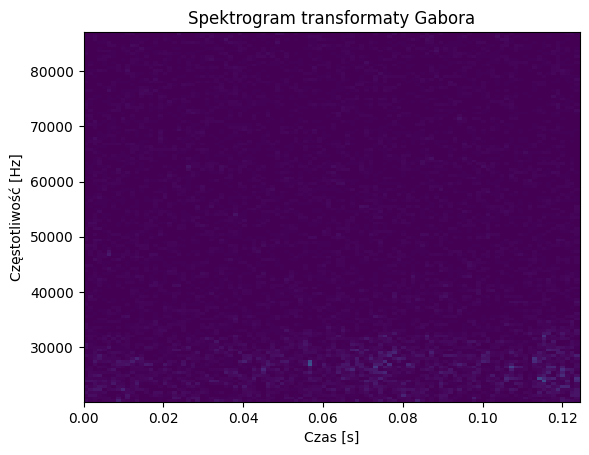

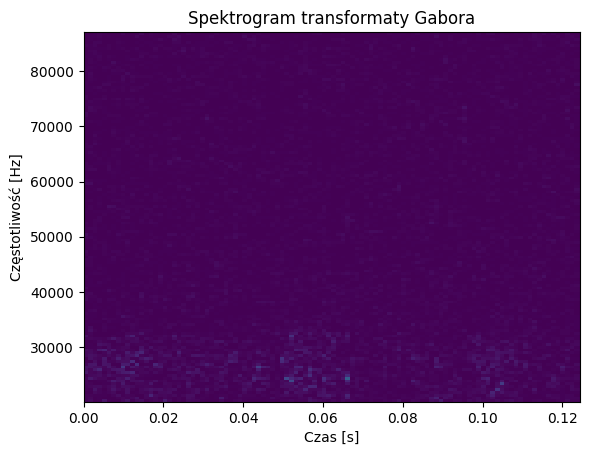

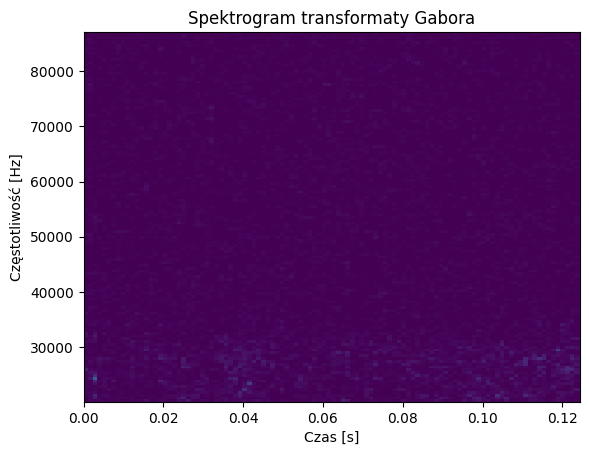

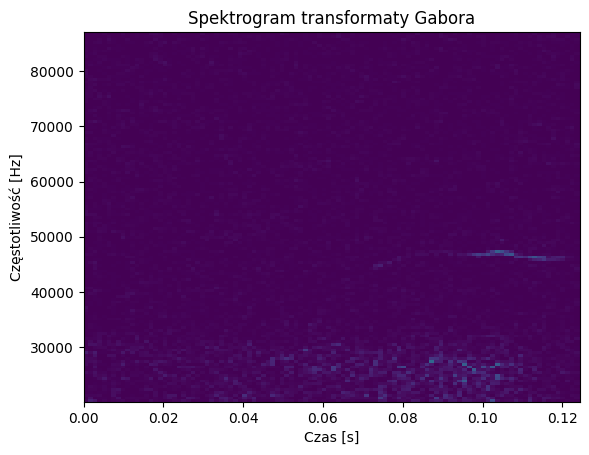

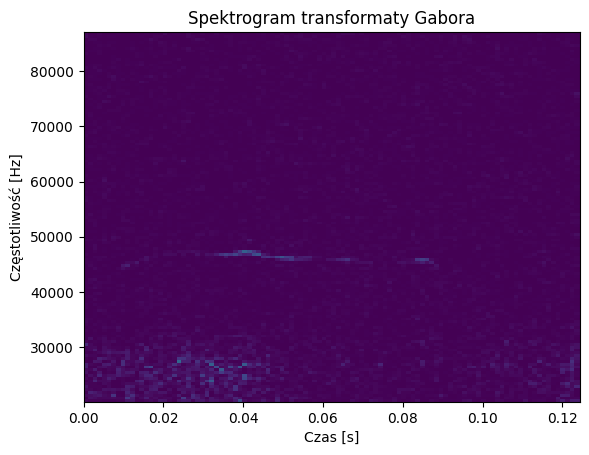

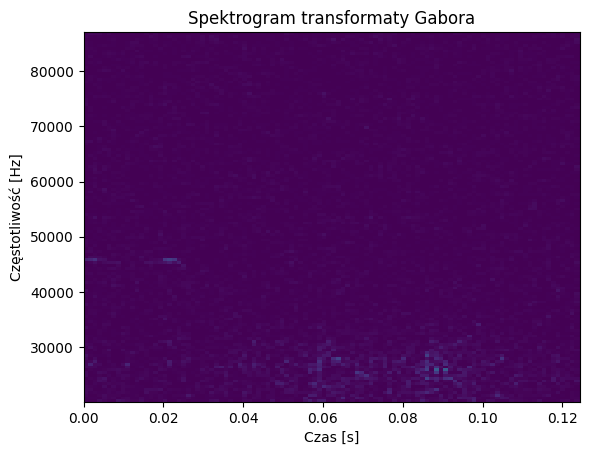

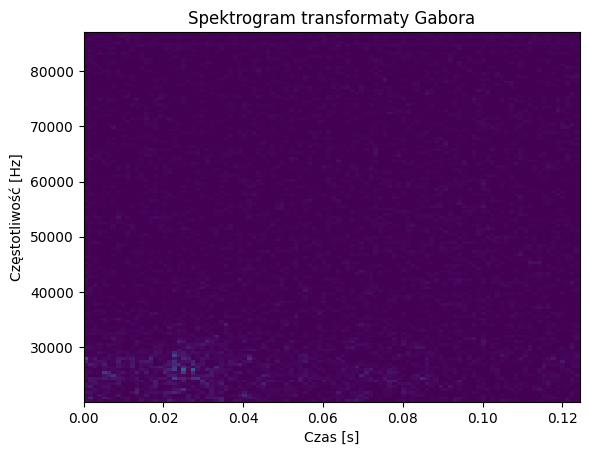

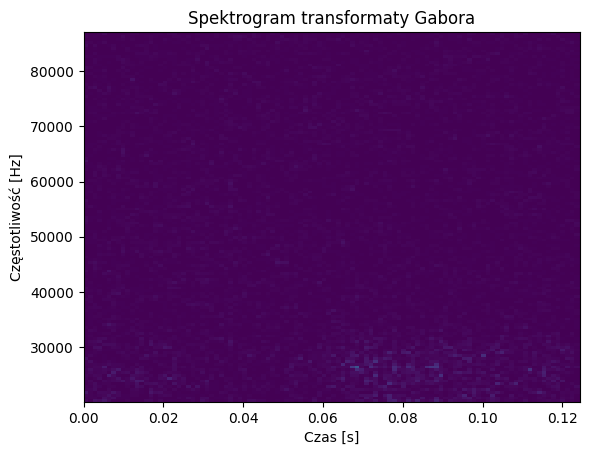

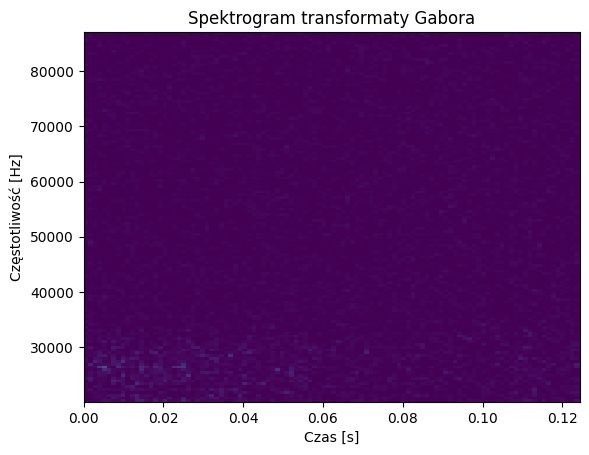

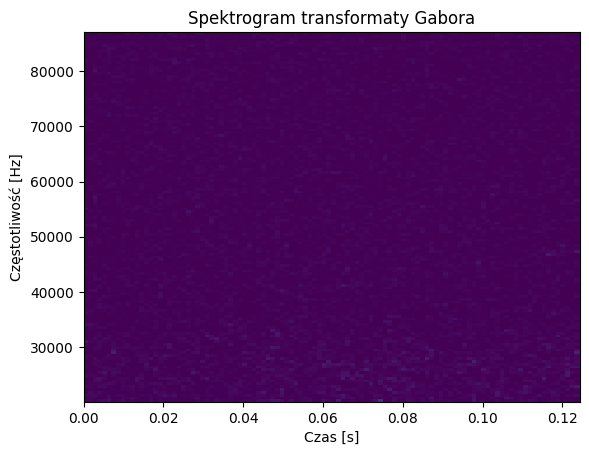

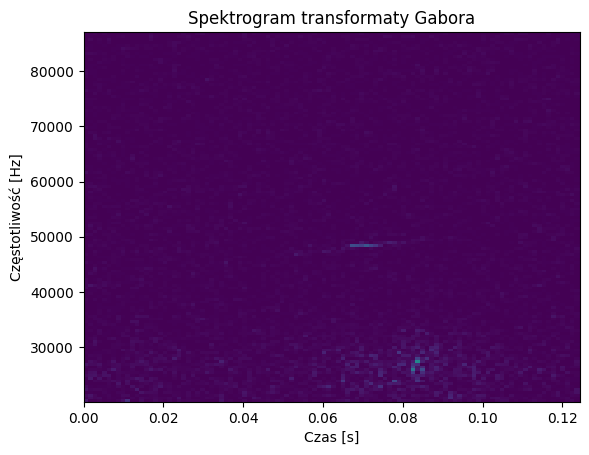

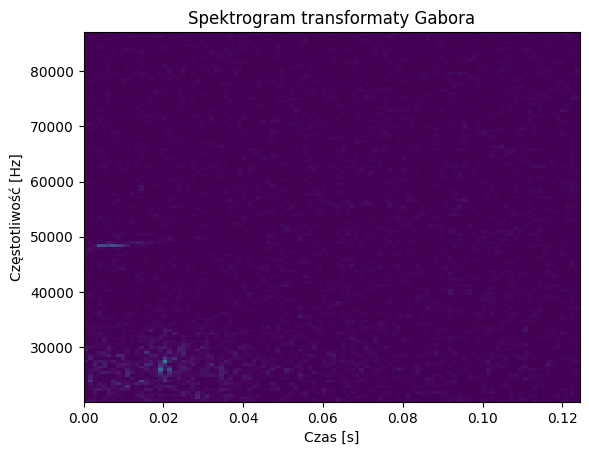

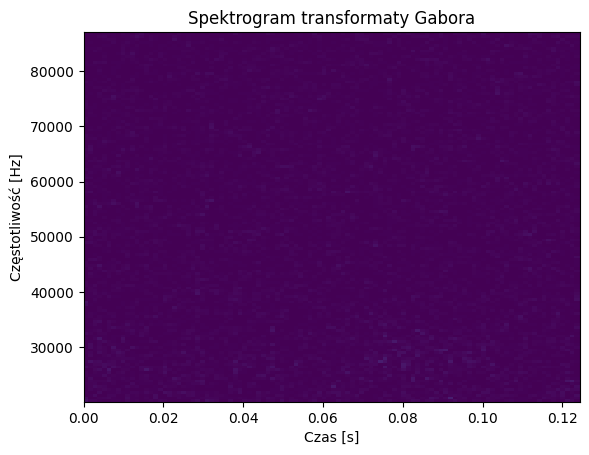

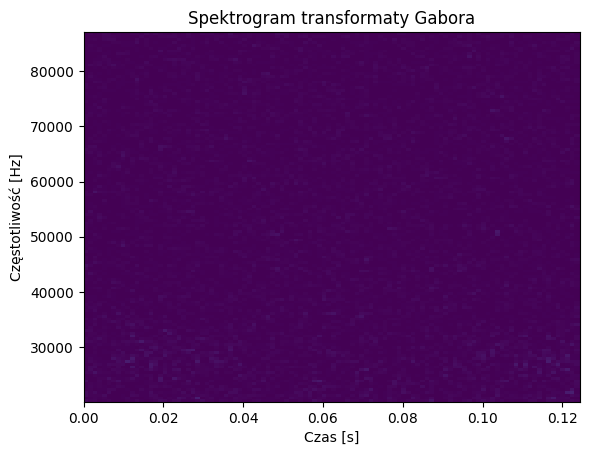

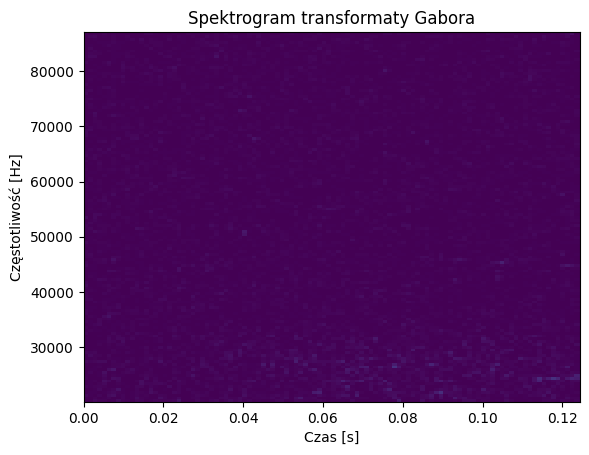

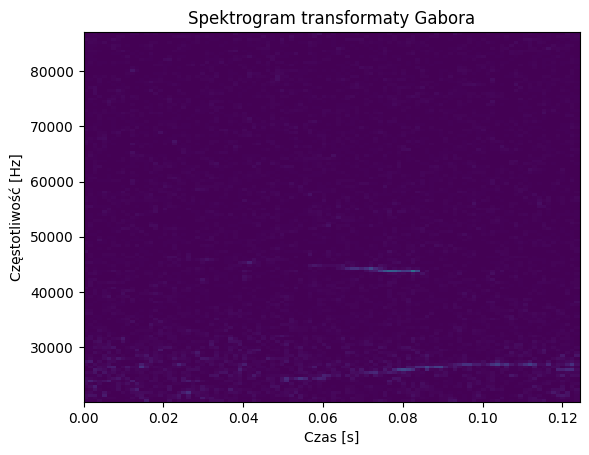

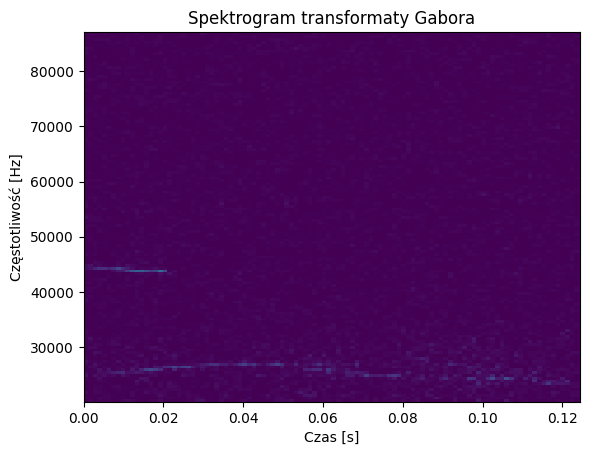

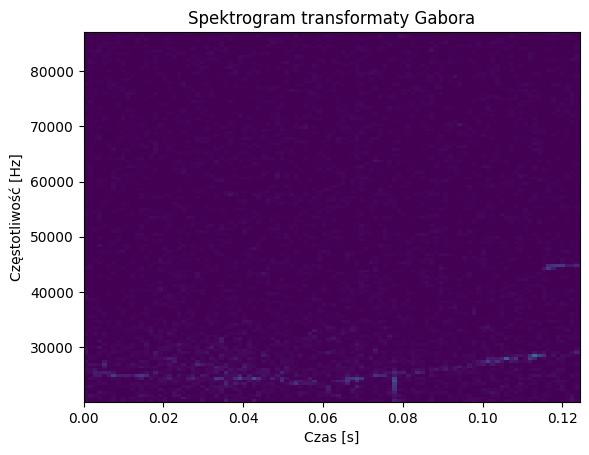

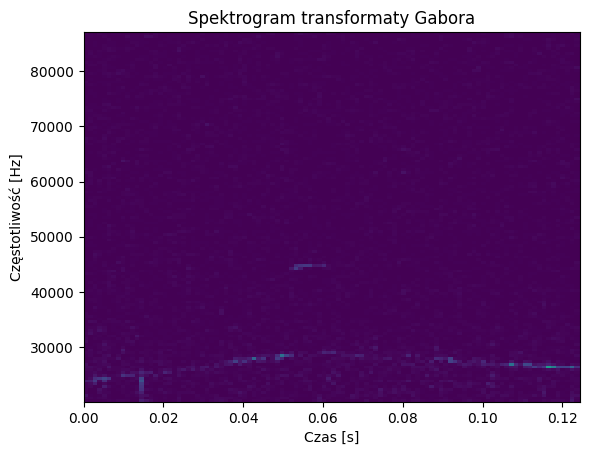

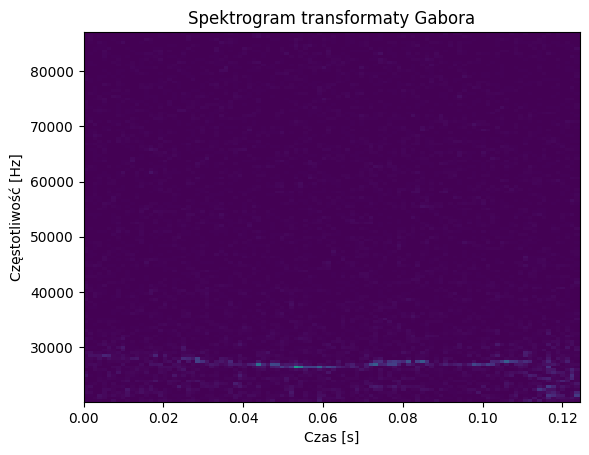

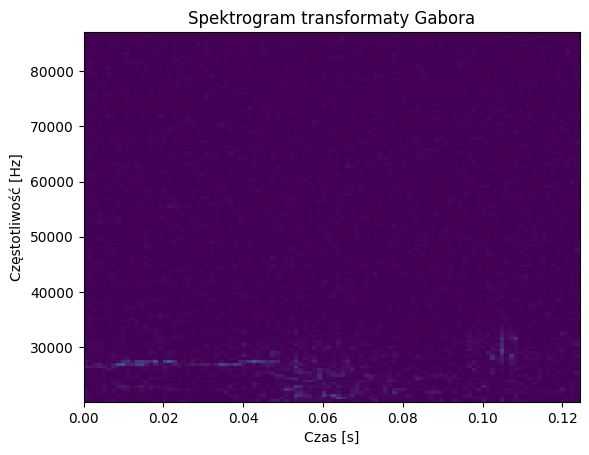

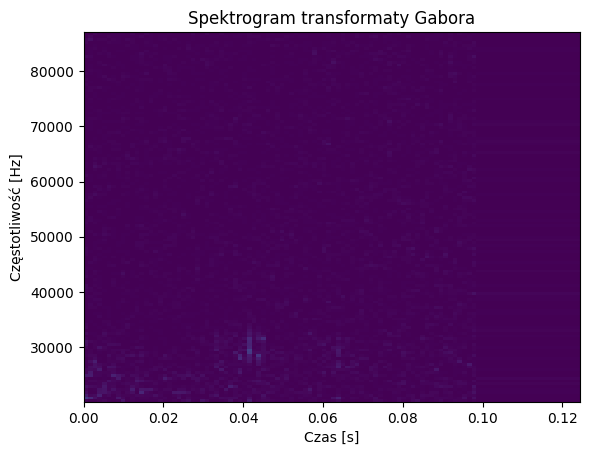

In [103]:
for one_rejected in rejected:
    plt.pcolormesh(part_t, part_f, one_rejected.reshape(IMAGE_SHAPE), vmax=0.5)
    plt.title('Spektrogram transformaty Gabora')
    plt.ylabel('Częstotliwość [Hz]')
    plt.xlabel('Czas [s]')
    plt.show()

In the rejected still are files with rat sounds, so I have to increase `confidence_level`.

In [104]:
confidence_level = 0.15
percentile_value = (1 - confidence_level)*100
perc = np.percentile(errors, percentile_value)
print(f"{percentile_value}th percentile: {perc}")
batch_size = 1
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
_ = next(stft_generator)
encoded_img = encoder.predict(stft_generator)
decoded_img = decoder.predict(encoded_img)
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
part_f, part_t = next(stft_generator)
i = 0
selected = []
rejected = []
for one_Sxx in stft_generator:
    metric = max_metric(one_Sxx, decoded_img[i])
    if metric > perc:
        selected.append(one_Sxx)
    else:
        rejected.append(one_Sxx)
    i += 1

85.0th percentile: 0.4387669637799263


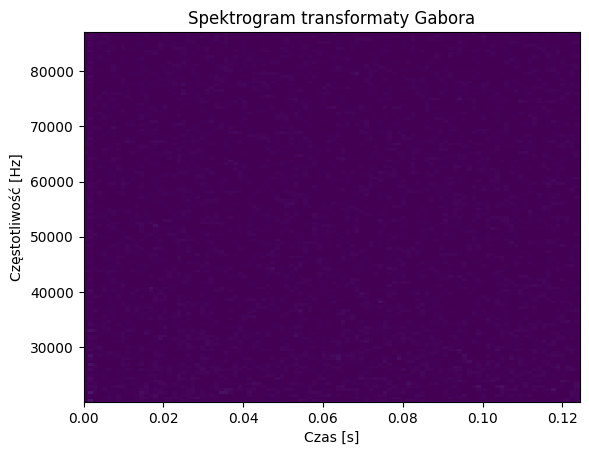

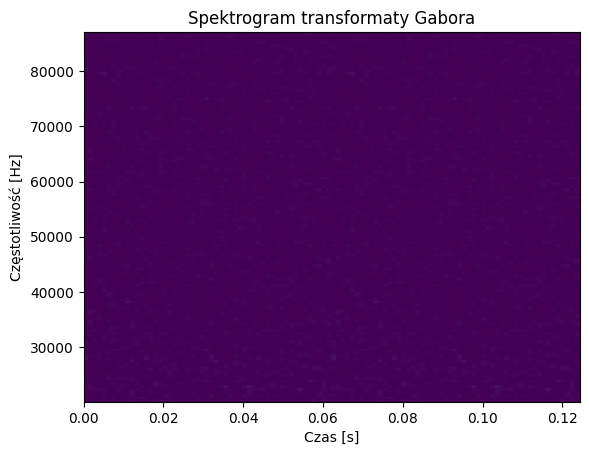

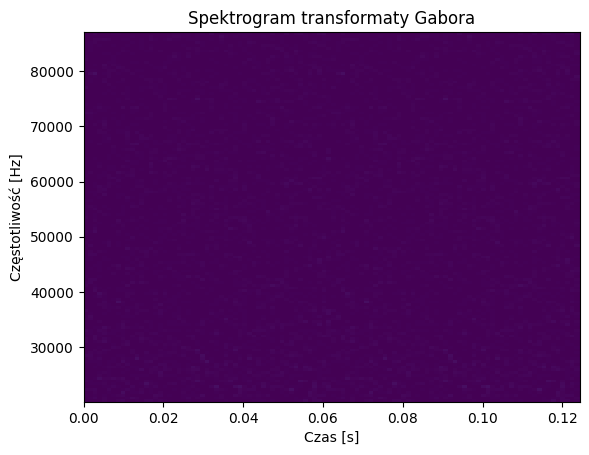

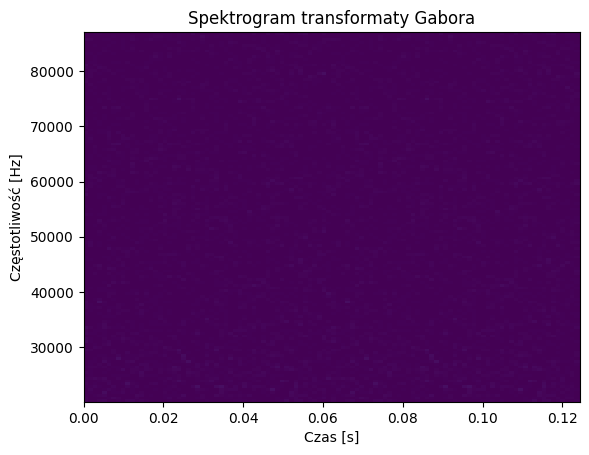

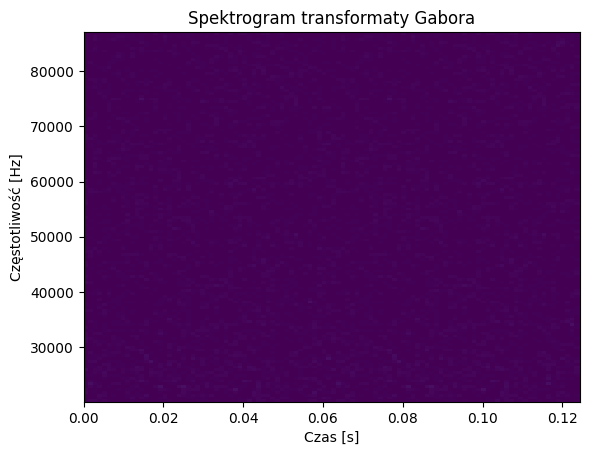

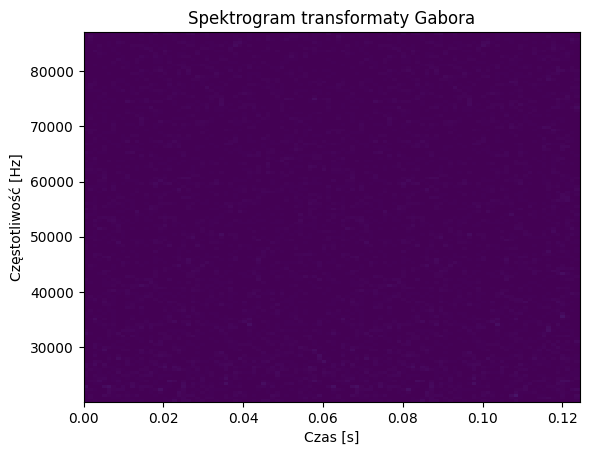

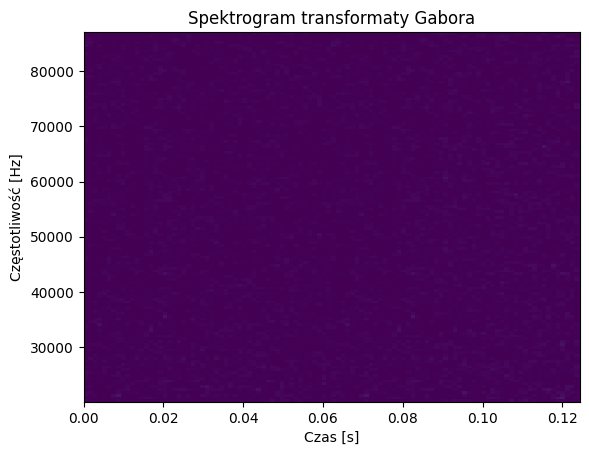

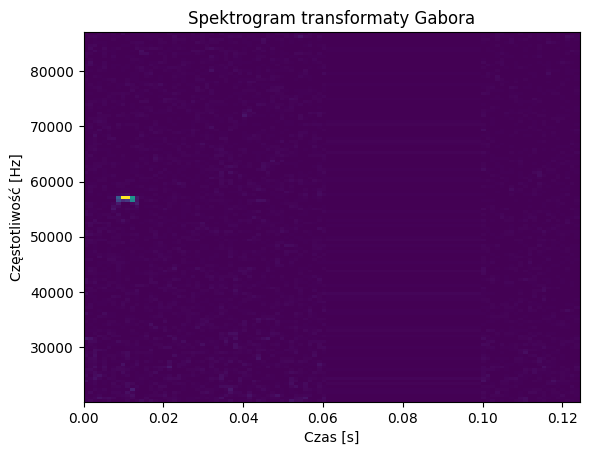

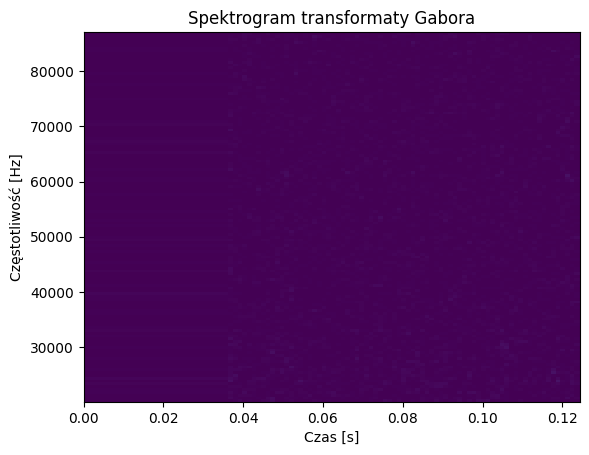

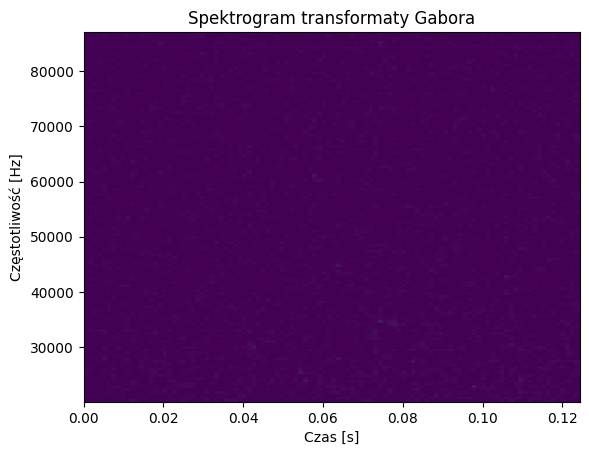

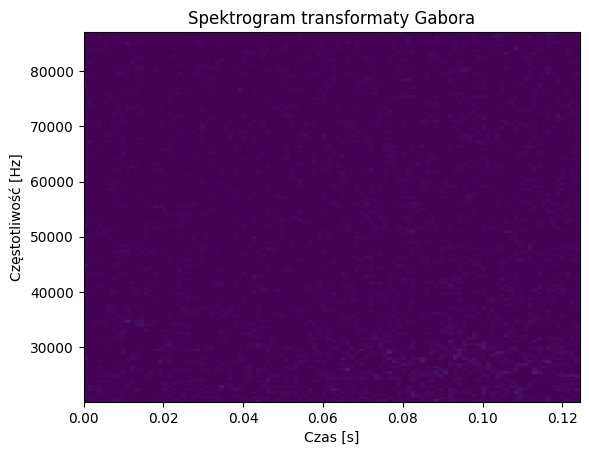

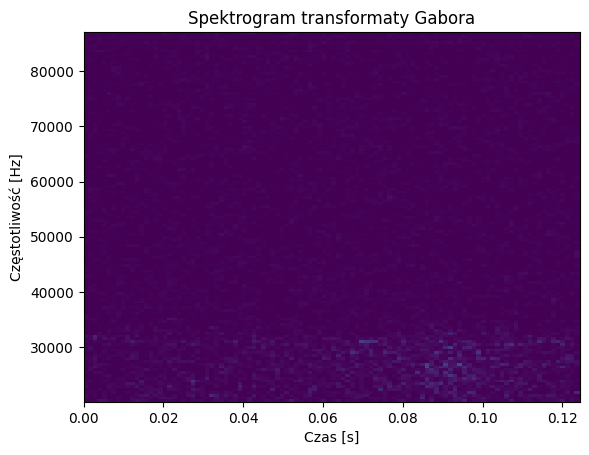

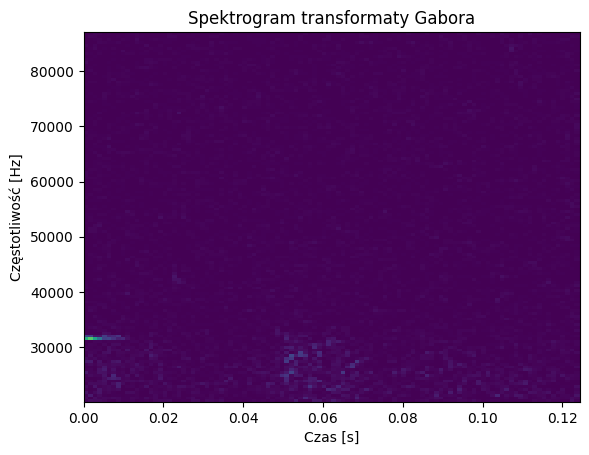

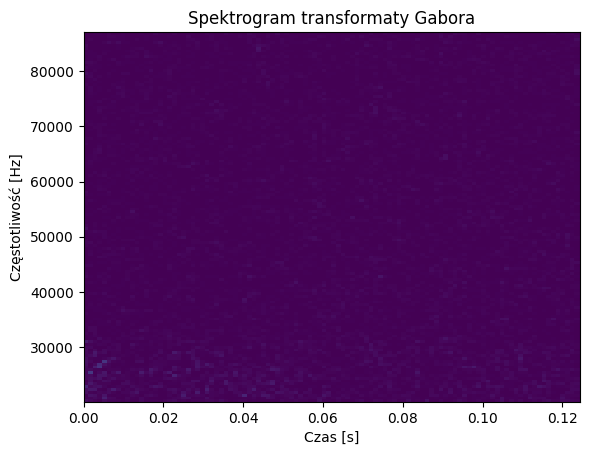

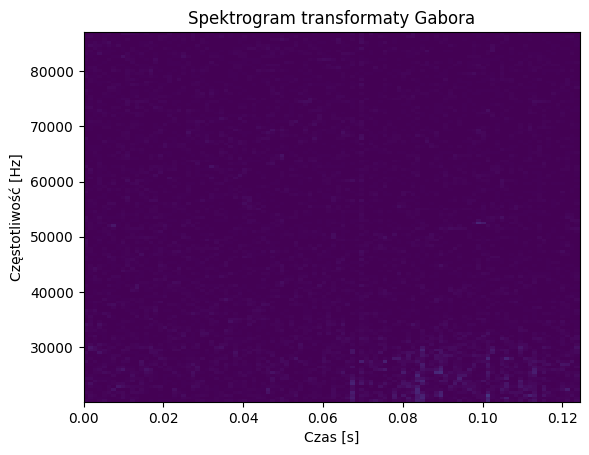

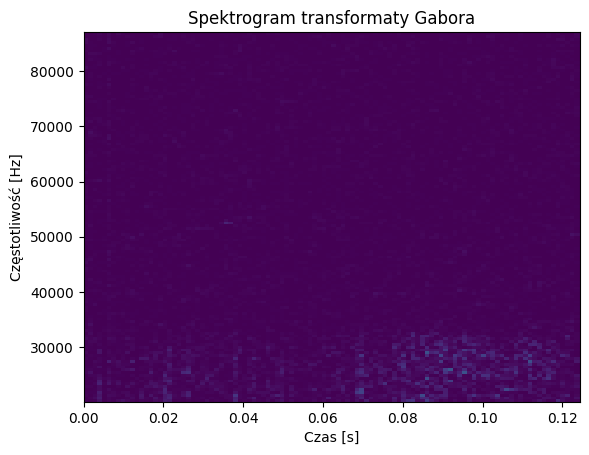

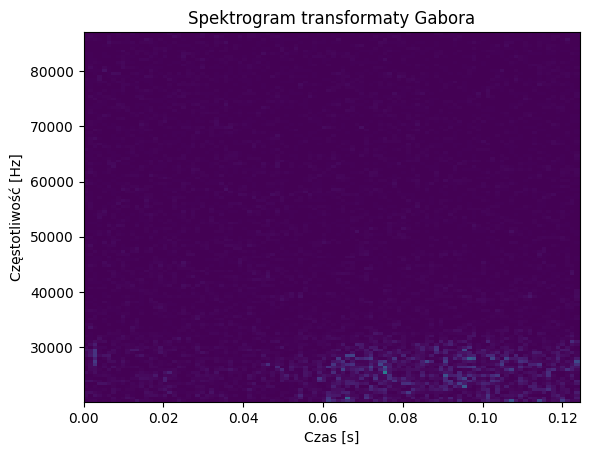

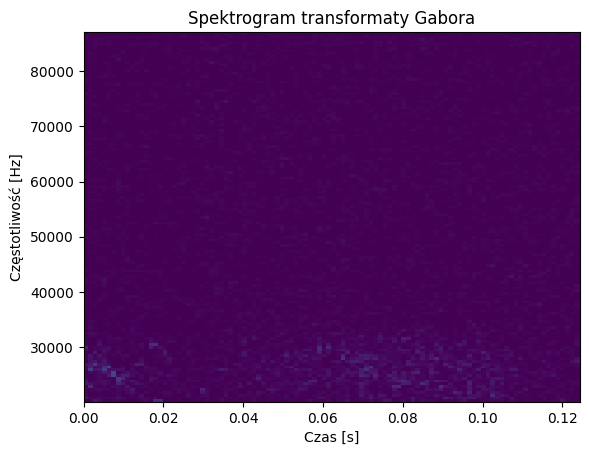

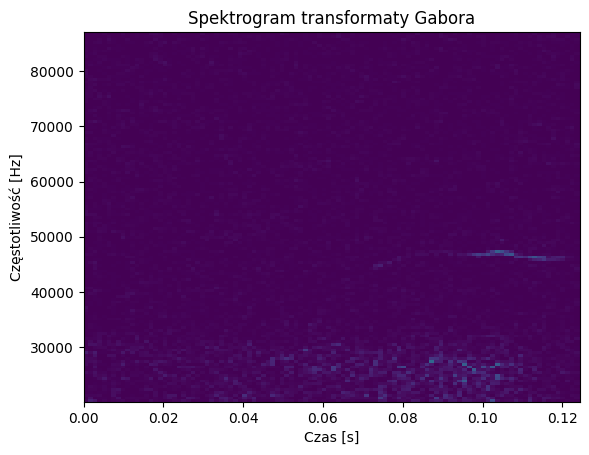

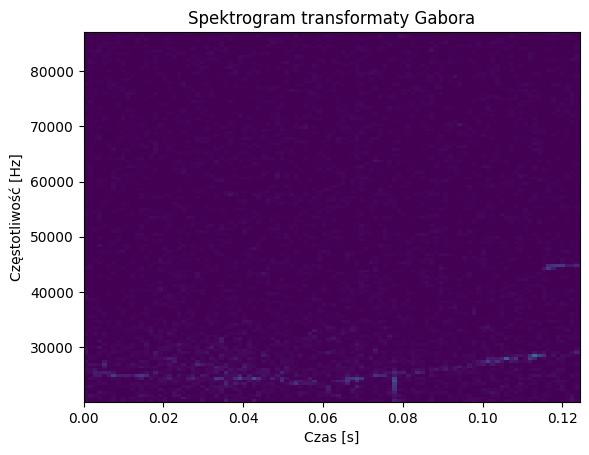

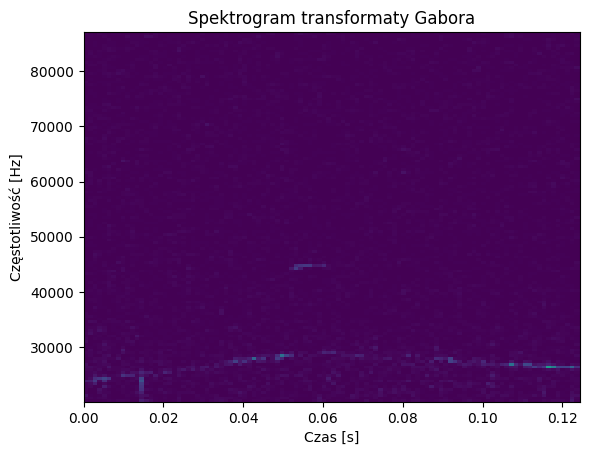

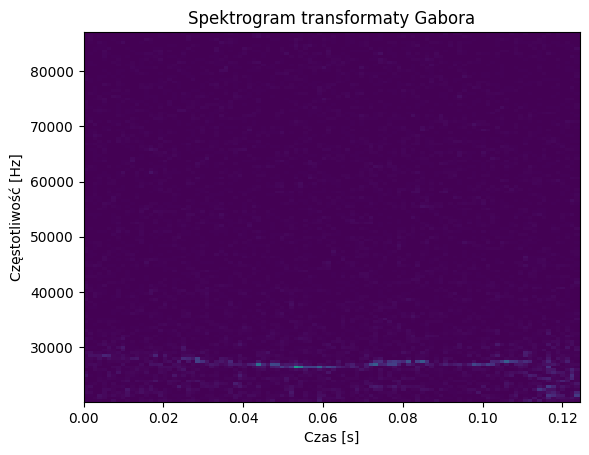

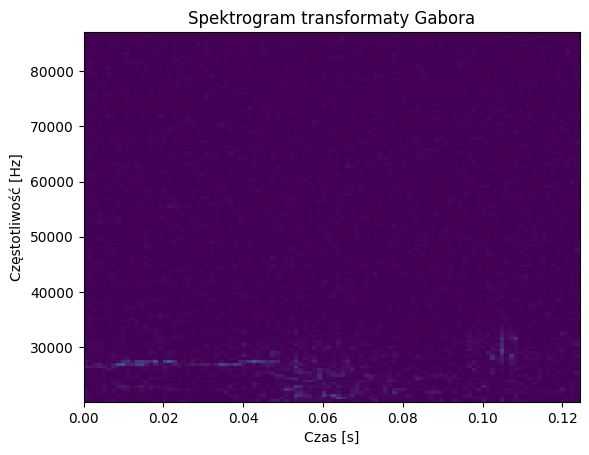

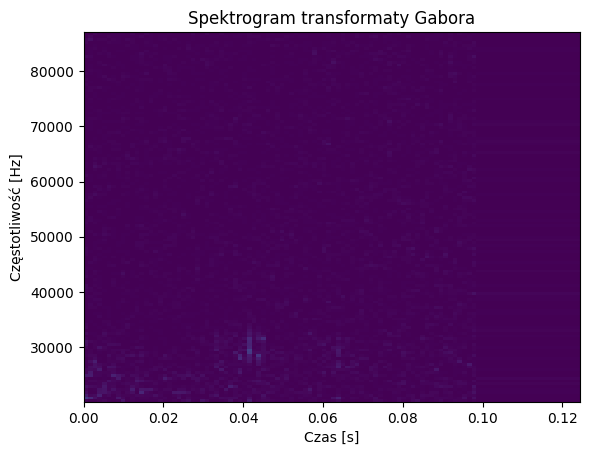

In [105]:
for one_rejected in rejected:
    plt.pcolormesh(part_t, part_f, one_rejected.reshape(IMAGE_SHAPE), vmax=0.5)
    plt.title('Spektrogram transformaty Gabora')
    plt.ylabel('Częstotliwość [Hz]')
    plt.xlabel('Czas [s]')
    plt.show()

75.0th percentile: 0.35206010192632675


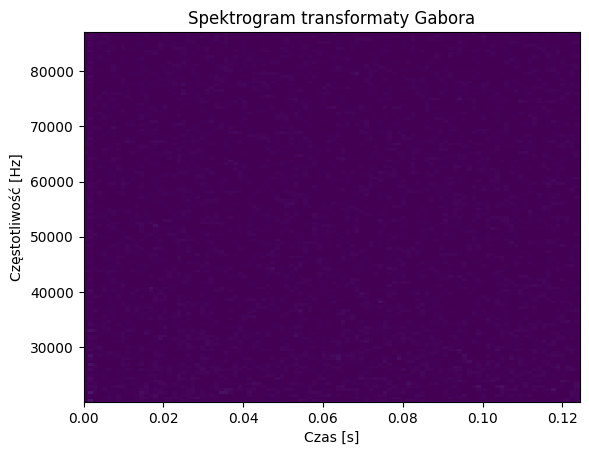

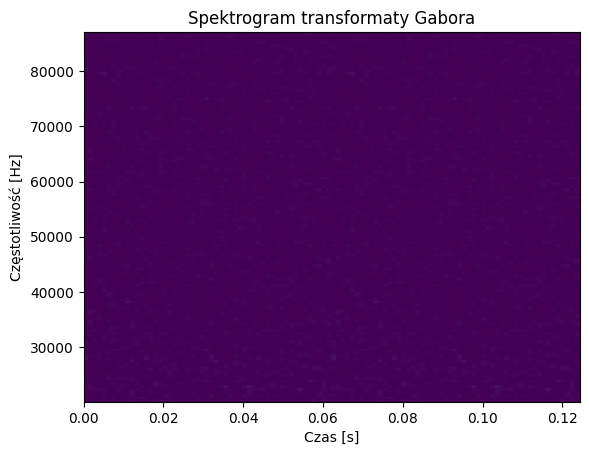

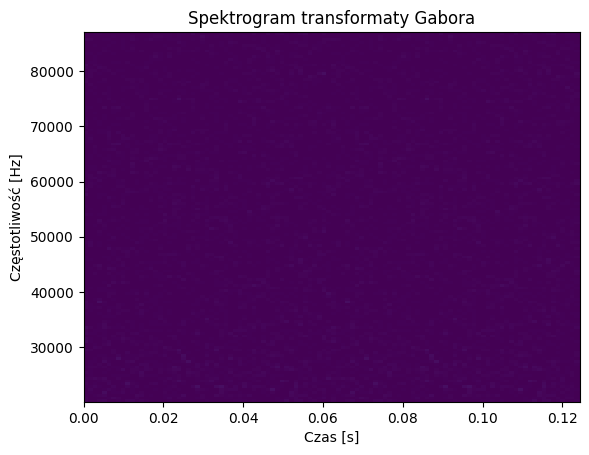

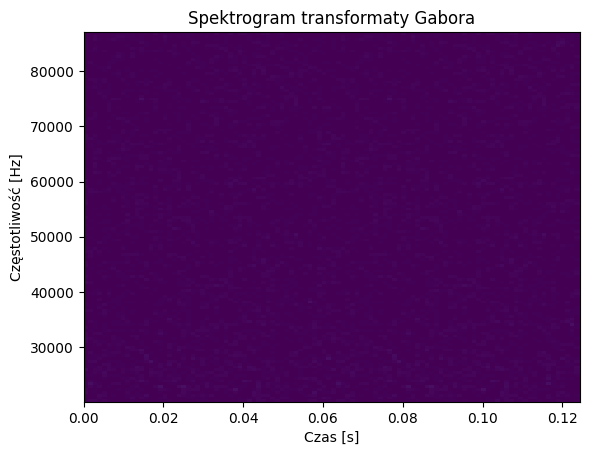

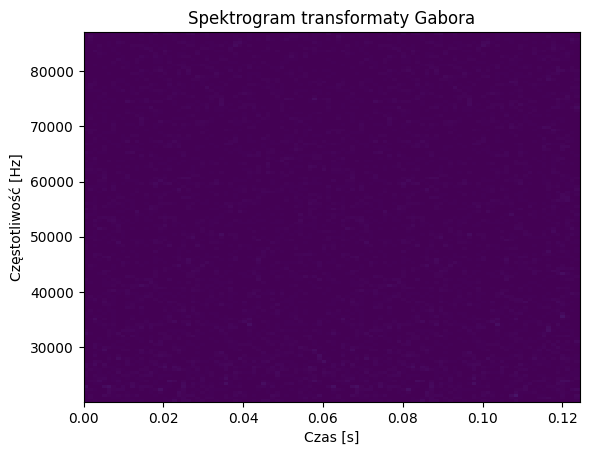

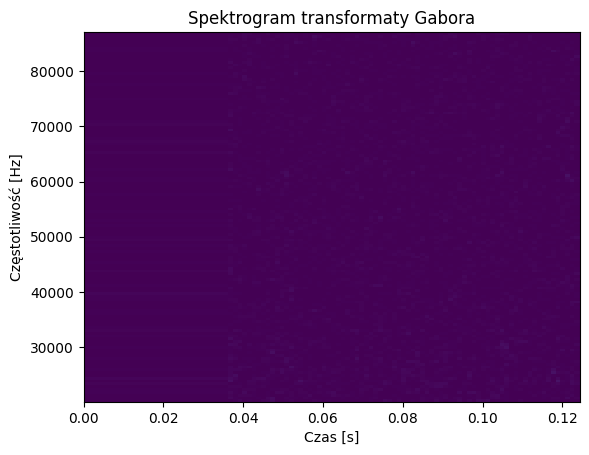

In [106]:
confidence_level = 0.25
percentile_value = (1 - confidence_level)*100
perc = np.percentile(errors, percentile_value)
print(f"{percentile_value}th percentile: {perc}")
batch_size = 1
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
_ = next(stft_generator)
encoded_img = encoder.predict(stft_generator)
decoded_img = decoder.predict(encoded_img)
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
part_f, part_t = next(stft_generator)
i = 0
selected = []
rejected = []
for one_Sxx in stft_generator:
    metric = max_metric(one_Sxx, decoded_img[i])
    if metric > perc:
        selected.append(one_Sxx)
    else:
        rejected.append(one_Sxx)
    i += 1
for one_rejected in rejected:
    plt.pcolormesh(part_t, part_f, one_rejected.reshape(IMAGE_SHAPE), vmax=0.5)
    plt.title('Spektrogram transformaty Gabora')
    plt.ylabel('Częstotliwość [Hz]')
    plt.xlabel('Czas [s]')
    plt.show()

Now I didn't detect any rat sounds. So I will try to decrease a little value of confidence level.

77.5th percentile: 0.3753192871809006


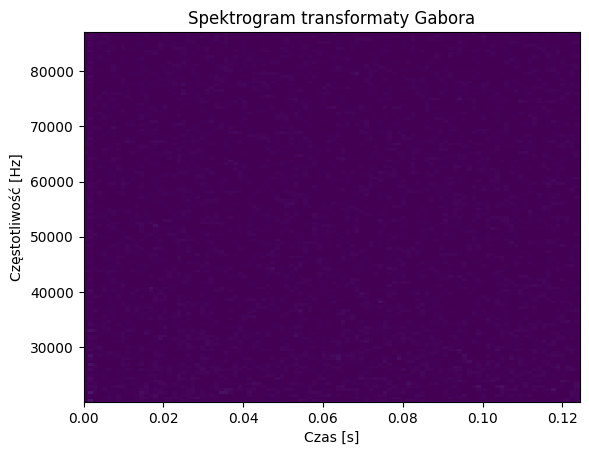

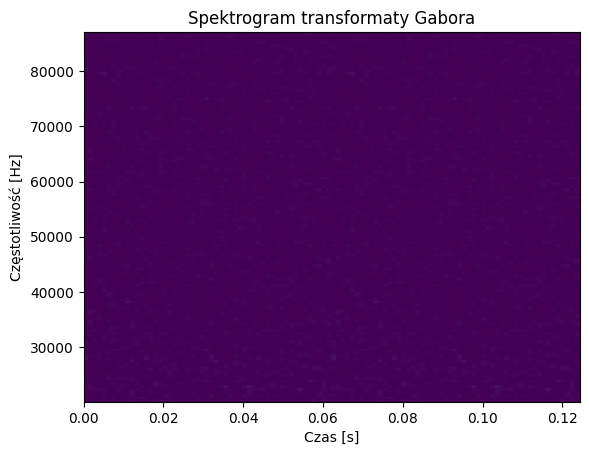

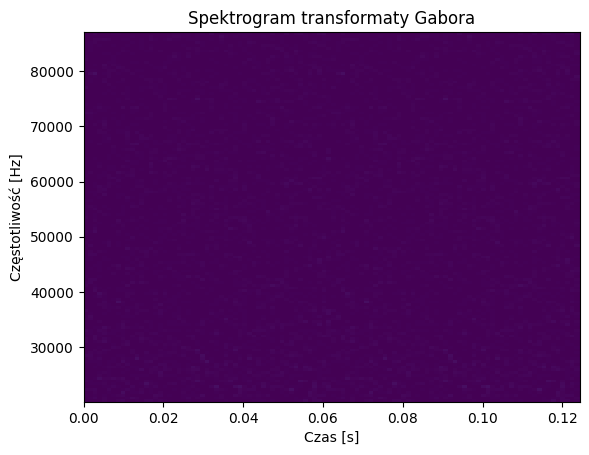

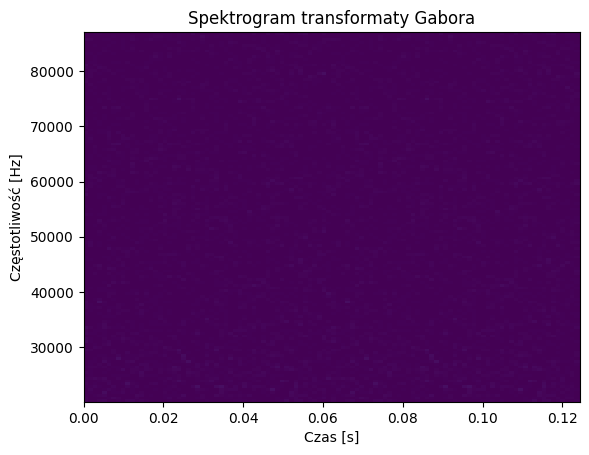

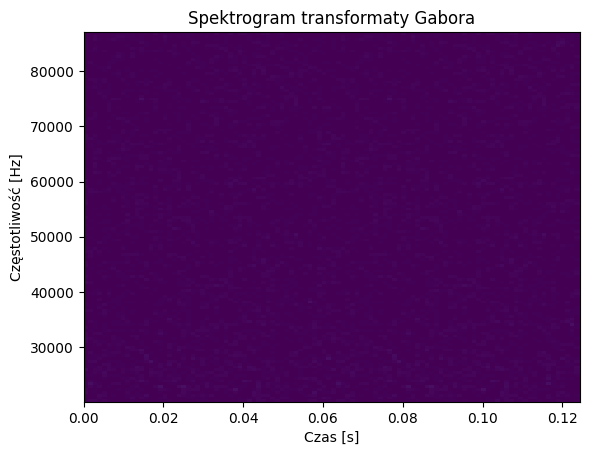

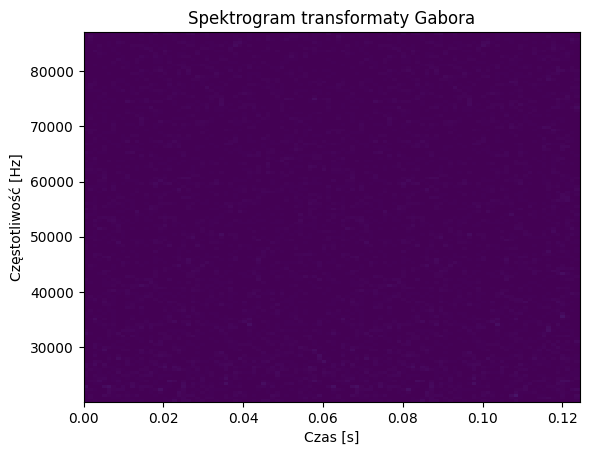

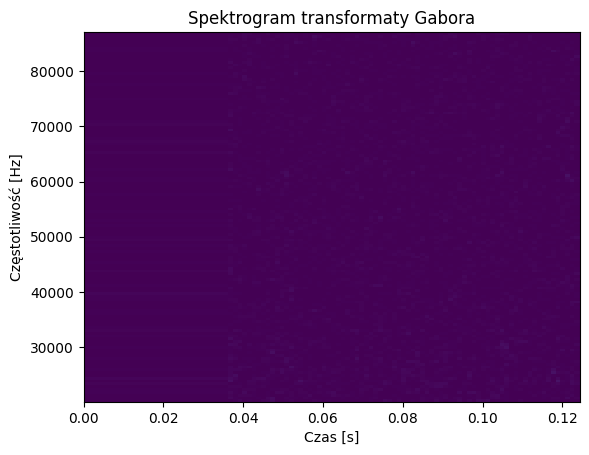

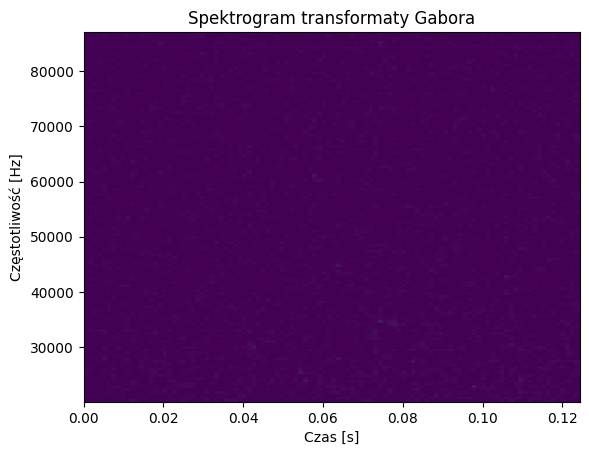

In [109]:
confidence_level = 0.225
percentile_value = (1 - confidence_level)*100
perc = np.percentile(errors, percentile_value)
print(f"{percentile_value}th percentile: {perc}")
batch_size = 1
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
_ = next(stft_generator)
encoded_img = encoder.predict(stft_generator)
decoded_img = decoder.predict(encoded_img)
stft_generator = filtered_intervals_generator_to_predict(file_path, batch_size=batch_size)
part_f, part_t = next(stft_generator)
i = 0
selected = []
rejected = []
for one_Sxx in stft_generator:
    metric = max_metric(one_Sxx, decoded_img[i])
    if metric > perc:
        selected.append(one_Sxx)
    else:
        rejected.append(one_Sxx)
    i += 1
for one_rejected in rejected:
    plt.pcolormesh(part_t, part_f, one_rejected.reshape(IMAGE_SHAPE), vmax=0.5)
    plt.title('Spektrogram transformaty Gabora')
    plt.ylabel('Częstotliwość [Hz]')
    plt.xlabel('Czas [s]')
    plt.show()

### Final threshold
Empirical way I checked that accurate therhold is 77.5th percentile for `confidence_level = 0.225` of metric `perc = 0.3753192871809006`. It means that selected files constitute 22.5% of the whole set. 

In [111]:
print(f"Amount of selected set: {confidence_level*len(errors)}")
print(f"Amount of rejected set: {(1 - confidence_level)*len(errors)}")

Amount of selected set: 90026.1
Amount of rejected set: 310089.9


This way we reduced dimensionality of dataset four times. \\
Figure below shows histogram of rejected files.

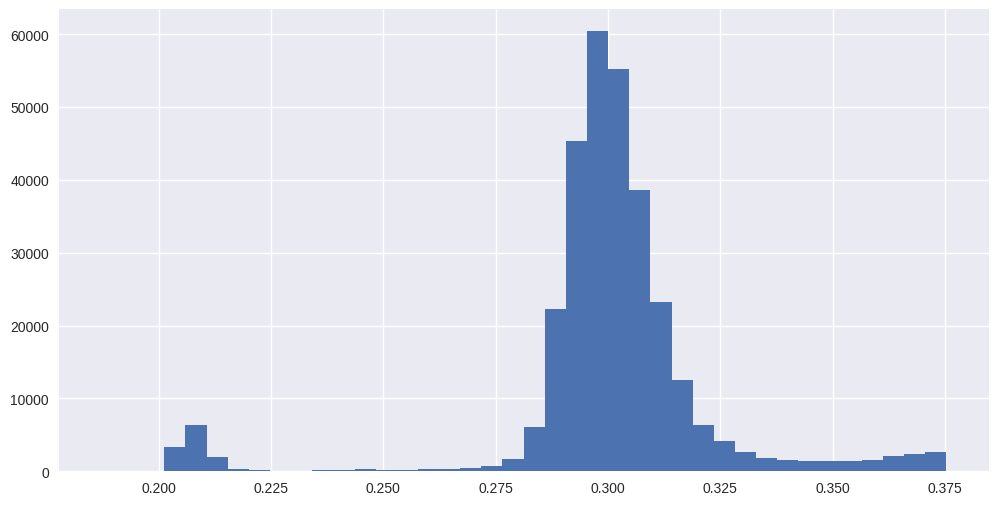

In [112]:
only_common_values = errors[np.where(errors<perc)]
plt.style.use('seaborn')
plt.figure(figsize=(12,6))
plt.hist(only_common_values, bins=40)
plt.show()

Outliers

The most values oscilates near 0, but outliers can have very big values.

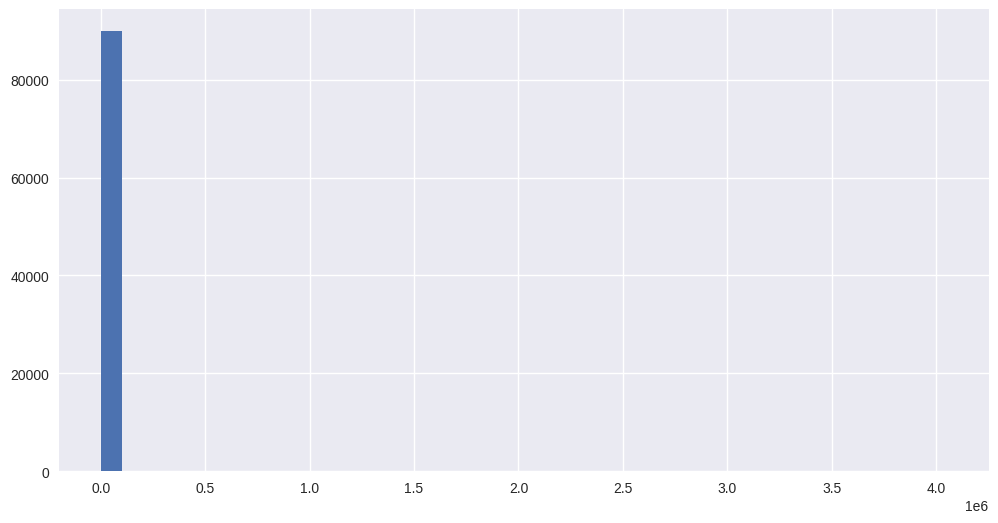

In [113]:
outliers = errors[np.where(errors>perc)]
plt.style.use('seaborn')
plt.figure(figsize=(12,6))
plt.hist(outliers, bins=40)
plt.show()

## Generate final results
I created a class ResultGenerator which analyses all files in specified directory and save a txt file with information about time interval of selected samples. 
## Conclusion
Using unspervised deep learning method I reduced a dataset to 22.5% of input dimension. In rejected files are only that one, which are without any rat sounds. In selected files are samples with rat sounds and rat breath, but also files without any rat sounds. \\
I had to be very careful with determining metric threshold, because every detected rat sound is important for project due to the smaller amount of such data. For defined therhold also a lot of not interesting files went to selected folder. \\
Due to the fact that I was working on a large data set I had to use generator for uploading files to the model in the fly, to avoid risk of overloading of RAM. I also preprocessed raw signal files to format which is accetable for neural network structures and can be used in further work. \\



## Further work
Presented results are only one idea of solution of this problem and can be solved with other algorithms. I decided to AutoEncoders because this model is manily used in similar problems. Another approach can be Convolutional Neural Networks which gives good results with image prediction and can learn patterns regardless of their location.  \\
For extracing only interesting files w can try with another settings of model, but we haven't confidence, that it helps. \\
Another approach is creating a stacking model. Stacking model is combination of two or more models. First model makes prediction from dataset, second one makes prediction from previous predicions and so on. In every step of this ensemble method reduce dimensionality of dataset and on the end we have only "anomaly of anomalies". Correct settings of model can give a as results only recordings with rat voices. 